# Practical Machine Learning for Physicists
## Week 6 Exercise 
## Deadline Monday 30th November at 12pm (Noon)

In this notebook you will be trying to predict a system using incomplete information. We will set up the equations of motions for a simple double pendulum (or should that be a double simple pendulum. Then we will see if a machine learning technique can predict the future position of the lower mass, using only the lower mass positions.

### Kinematics of the double pendulum
Let's specify our problem in terms of the following, with the origin at the pivot point of the top pendulum. This is just background for the machine learning tasks at the bottom of the notebook.

#### Positions
$$x_1 = L_1 \sin \theta_1$$
$$y_1 = -L_1 \cos \theta_1$$
$$x_2 = x_1 + L_2 \sin \theta_2$$
$$y_2 = y_1 - L_2 \cos \theta_2$$

#### Velocities
$$\dot{x}_1 = \dot{\theta_1} L_1 \cos \theta_1$$
$$\dot{y_1} =  \dot{\theta_1} L_1 \sin \theta_1$$
$$\dot{x_2} = \dot{x_1} + \dot{\theta_2} L_2 \cos \theta_2$$
$$\dot{y_2} = \dot{y_1} + \dot{\theta_2} L_2 \sin \theta_2$$


#### Accelerations

$$\ddot{x}_1 = -\dot{\theta_1}^2 L_1 \sin \theta_1 + \ddot{\theta_1} L_1 \cos \theta_1$$
$$\ddot{y_1} =  \dot{\theta_1}^2 L_1 \cos \theta_1 + \ddot{\theta_1} L_1 \sin \theta_1$$
$$\ddot{x_2} = \ddot{x_1} - \dot{\theta_2}^2 L_2 \sin \theta_2 + \ddot{\theta_2} L_2 \cos \theta_2$$
$$\ddot{y_2} = \ddot{y_1} + \dot{\theta_2}^2 L_2 \cos \theta_2 + \ddot{\theta_2} L_2 \sin \theta_2$$

#### Energies
Let $v_1^2 = \dot{x_1}^2 +\dot{y_1}^2$ and $v_2^2 = \dot{x_2}^2 +\dot{y_2}^2$ then the kinetic energies $T_1$ and $T_2$ are
$$ T_1 = \frac{1}{2}m_1 v_1^2 = \frac{1}{2}m_1 L_1^2 \dot{\theta_1}^2 $$
$$ T_2 = \frac{1}{2}m_2 v_2^2 = \frac{1}{2}m_2 \left( L_1^2 \dot{\theta_1}^2 + L_2^2 \dot{\theta_2}^2 + 2L_1 L_2 \cos(\theta_1-\theta_2) \dot{\theta_1} \dot{\theta_2} \right) $$

The potential enrgies are
$$V_1 = m_1 g y_1 = - m_1 g L_1 \cos \theta_1$$
$$V_2 = m_2 g y_2 = -m_2 g ( L_1 \cos \theta_1 + L_2 \cos \theta_2)$$

#### Langrangian
Now we form the Lagrangian $L=T-V=T_1+T_2 -V_1 -V_2$ and use the Euler-Lagrange equations:
$$\frac{\partial L}{\partial \theta_1} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_1}}$$
$$\frac{\partial L}{\partial \theta_2} = \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta_2}}$$

Applying these gives
$$-(m_1+m_2) g L_1 \sin \theta_1 = (m_1+m_2) L_1^2 \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_2}^2 +  m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_2} $$
and
$$ -m_2 g L_2 \sin \theta_2 = m_2 L_2 \ddot{\theta_2} + m_2 L_1 L_2 \cos(\theta_1-\theta_2) \ddot{\theta_1} + m_2 L_1 L_2 \sin(\theta_1-\theta_2) \dot{\theta_1}^2 $$ 


#### Equations of motions
$$ \omega_1 = \dot{\theta_1}$$  

$$ \omega_2 = \dot{\theta_2}$$ 
$$ \ddot\theta_1 = \frac{1}{L_1\xi}\left[L_1m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_1^2 + L_2m_2\sin(\theta_1-\theta_2)\omega_2^2 - m_2g\cos(\theta_1-\theta_2)\sin(\theta_2) + (m_1+m_2)g\sin(\theta_1) \right] $$
$$ \ddot\theta_2 = \frac{1}{L_2\xi}\left[L_2m_2\cos(\theta_1-\theta_2)\sin(\theta_1-\theta_2)\omega_2^2 + L_1(m_1+m_2)\sin(\theta_1-\theta_2)\omega_1^2+(m_1+m_2)g\sin(\theta_1)\cos(\theta_1-\theta_2) - (m_1+m_2)g\sin(\theta_2) \right] $$
where 
$$\xi \equiv \cos^2(\theta_1-\theta_2)m_2-m_1-m_2$$


In [11]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.integrate import solve_ivp

import matplotlib.style #Some style nonsense
import matplotlib as mpl #Some more style nonsense

#Set default figure size
#mpl.rcParams['figure.figsize'] = [12.0, 8.0] #Inches... of course it is inches
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 # dots per inch



In [12]:
def rhs(t, z, L1, L2, m1, m2, g):
    """
    Returns the right-hand side of the ordinary differential equation describing the double pendulem
    """
    theta1, w1, theta2, w2 = z    #The four components
    cos12 = np.cos(theta1 - theta2)
    sin12 = np.sin(theta1 - theta2)
    sin1 = np.sin(theta1)
    sin2 = np.sin(theta2)
    xi = cos12**2*m2 - m1 - m2
    w1dot = ( L1*m2*cos12*sin12*w1**2 + L2*m2*sin12*w2**2
            - m2*g*cos12*sin2      + (m1 + m2)*g*sin1)/(L1*xi)
    w2dot = -( L2*m2*cos12*sin12*w2**2 + L1*(m1 + m2)*sin12*w1**2
            + (m1 + m2)*g*sin1*cos12  - (m1 + m2)*g*sin2 )/(L2*xi)
    return w1, w1dot, w2, w2dot   #Return the w's and the wdot's


def to_cartesian(theta1, w1, theta2, w2, L1, L2):
    """ Transforms theta and omega to cartesian coordinates
    and velocities x1, y1, x2, y2, vx1, vy1, vx2, vy2
    """
    x1 = L1 * np.sin(theta1)
    y1 = -L1 * np.cos(theta1)
    x2 = x1 + L2 * np.sin(theta2)
    y2 = y1 - L2 * np.cos(theta2)
    vx1 = L1*np.cos(theta1)*w1
    vy1 = L1*np.sin(theta1)*w1
    vx2 = vx1 + L2*np.cos(theta2)*w2
    vy2 = vy1 + L2*np.sin(theta2)*w2
    return x1, y1, x2, y2, vx1, vy1, vx2, vy2
    

In [13]:
# Set up the initial conditions. Here we have lengths and masses
L1, L2 = 1., 1.
m1, m2 = 3., 1.
g = 9.81     # [m/s^2]. Gravitational acceleration

#Starting angles
z0=[np.pi/4,0,np.pi/4,0]
#z0=[0.1,0,0.1,0]

#Time ranges
tmax, dt = 50, 0.1
t = np.arange(0, tmax+dt, dt)

In [14]:
# Solve initial value problem
ret = solve_ivp(rhs, (0,tmax), z0, t_eval=t, args=(L1, L2, m1, m2, g))
z=ret.y
print(np.shape(z))

# Extract result
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(4, 501)


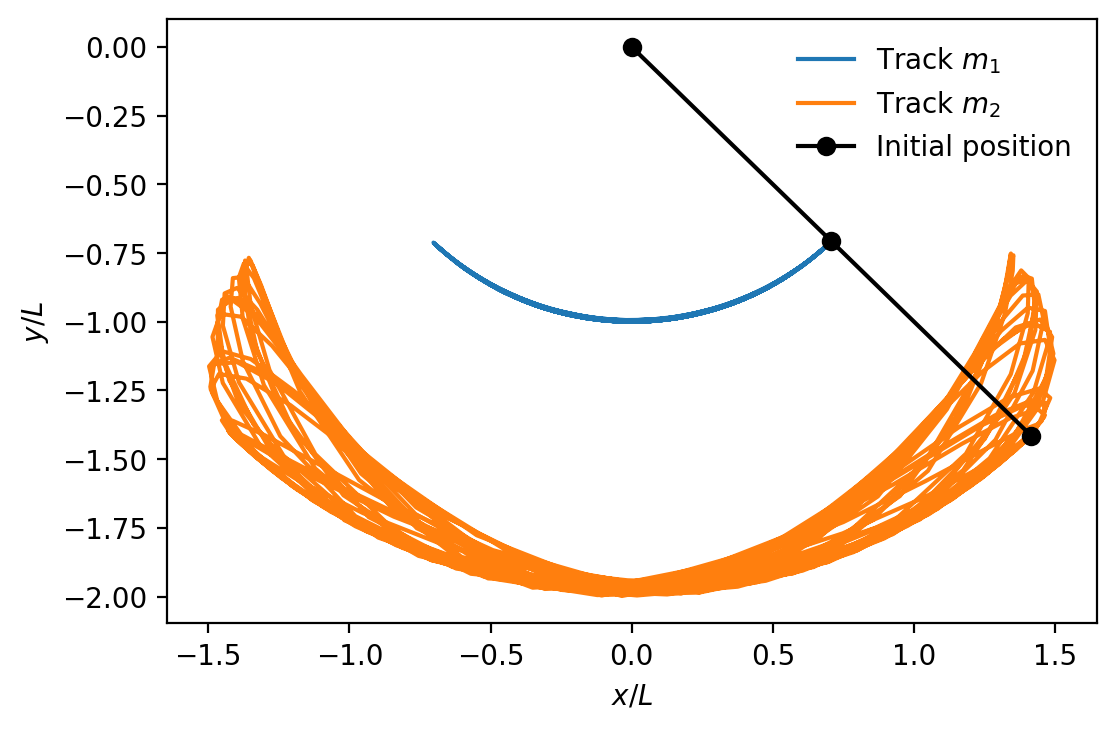

In [15]:
fig,ax=plt.subplots()
ax.plot(x1, y1, label=r"Track $m_1$")
ax.plot(x2, y2, label=r"Track $m_2$")
ax.plot([0, x1[0], x2[0]], [0, y1[0], y2[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# Exercises: Predicting Chaos
1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 
2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp
3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)
4. Repeat steps 1-3 for the initial conditions $z_0=[\pi/2,0,\pi/2,0]$ which give a much more complex path.
5. Repeat steps 1-4 but only train your neural network on the cartesian coordinates of the mass $m_2$ (i.e without showing your neural network the positions of the mass $m_1$)



In [16]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

#Import tqdm for progress bar
from tqdm import tqdm

# 1. Design and train a recurrent neural network (of your choice) to predict the future positions, where future is defined as $t=t_0 + 20 \delta t$, of the masses $m_1$ and $m_2$ using their cartesian coordinates and the initial conditions  $z_0=[\pi/4,0,\pi/4,0]$. 

Firstly we need to define a simple network using one LSTM layer with 50 neurons and then a Dense layer to map to 4 different outputs: the x and y positions of both the masses $m_1$ and $m_2$.

Let us start by defining a function to create our model

In [17]:
#Define function to initialise LSTM model with 4 imputs and 4 outputs
def create_model():
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(40,input_shape=(None,4),return_sequences=False)) # LSTM layer with 50 neurons
    #model.add(keras.layers.LSTM(40,input_shape=(None,40),return_sequences=False)) # LSTM layer with 50 neurons
    model.add(keras.layers.Dense(4,activation="linear"))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

Now we need to define the windowsize and the offset for the LSTM network. Also we need to reshape our input and target arrays used to train the model

In [18]:
windowsize=20 #Number of samples we will use to train our network
offset=20 #How many samples into the future to predict

#This function splits up a 1-d array x into a series of overlapping windows
#The return is a tuple of the array of input windows and target (label) windows
def shapeArray(x,windowsize,offset):
    xInput= np.array([x[i : i + windowsize] for i in range(len(x)-(windowsize+offset)+1)])
    xLabel= np.array([x[i +windowsize : i+ windowsize+offset] for i in range(len(x)-(windowsize+offset)+1)])
    return (xInput,xLabel)

In [19]:
def get_input_target(t,windowsize,offset):
    # calculate the cartesian coordinates using the solve_ivp function
    ret = solve_ivp(rhs, (0,max(t)), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
    x1, y1, x2, y2, vx1, vy1, vx2, vy2 = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    
    # Reshaping arrays:    
    x1_In,x1_Lab=shapeArray(x1,windowsize,offset)
    y1_In,y1_Lab=shapeArray(y1,windowsize,offset)
    x2_In,x2_Lab=shapeArray(x2,windowsize,offset)
    y2_In,y2_Lab=shapeArray(y2,windowsize,offset)
        
    x1_in=x1_In.reshape(x1_In.shape[0],x1_In.shape[1],1)     # Reshape the input array to have the dimensions (batchsize,time samples, features)
    x2_in=x2_In.reshape(x2_In.shape[0],x2_In.shape[1],1)     # Reshape the input array to have the dimensions (batchsize,time samples, features)
    y1_in=y1_In.reshape(y1_In.shape[0],y1_In.shape[1],1)     # Reshape the input array to have the dimensions (batchsize,time samples, features)
    y2_in=y2_In.reshape(y2_In.shape[0],y2_In.shape[1],1)     # Reshape the input array to have the dimensions (batchsize,time samples, features)

    x1_target=x1_Lab[:,-1].reshape(x1_Lab.shape[0],1)     # Reshape the input array to have the dimensions (batchsize, features)
    x2_target=x2_Lab[:,-1].reshape(x2_Lab.shape[0],1)     # Reshape the input array to have the dimensions (batchsize, features)
    y1_target=y1_Lab[:,-1].reshape(y1_Lab.shape[0],1)     # Reshape the input array to have the dimensions (batchsize, features)
    y2_target=y2_Lab[:,-1].reshape(y2_Lab.shape[0],1)     # Reshape the input array to have the dimensions (batchsize, features)

    Input=np.array([x1_in, y1_in, x2_in, y2_in]).reshape(x1_In.shape[0],x1_In.shape[1],4)   
    Target=np.array([x1_target,y1_target,x2_target,y2_target]).reshape(y2_Lab.shape[0],4)
    
    return Input,Target   

Now we will train the network for 300 steps, and plot the cost against the steps.

100%|██████████| 300/300 [00:30<00:00,  9.73it/s]


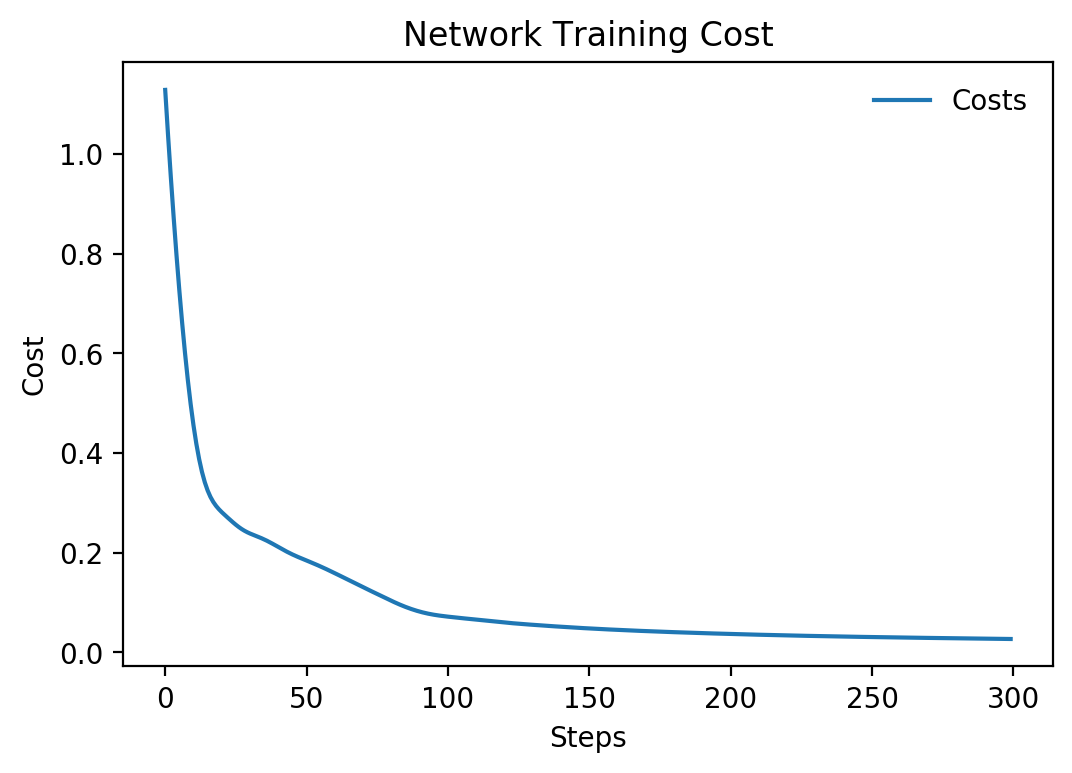

In [20]:
model=create_model()

steps=300                          #Number of training steps
costs=np.zeros(steps)              #Array for plotting cost
for i in tqdm(range(steps)):
    tmax, dt = 50, 0.1         
    t = np.arange(0, tmax+dt, dt)  # Arrray of time values
    
    Input,Target=get_input_target(t,windowsize,offset)  # getting input and target coordinate values
    costs[i]=model.train_on_batch(Input,Target)         #Train the network

#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
ax.legend()

In [21]:
print(f'The final costs of the network is: {costs[-1]}')

The final costs of the network is: 0.026781560853123665


Let us now plot the network predicted trajectories for the double pendulum system.

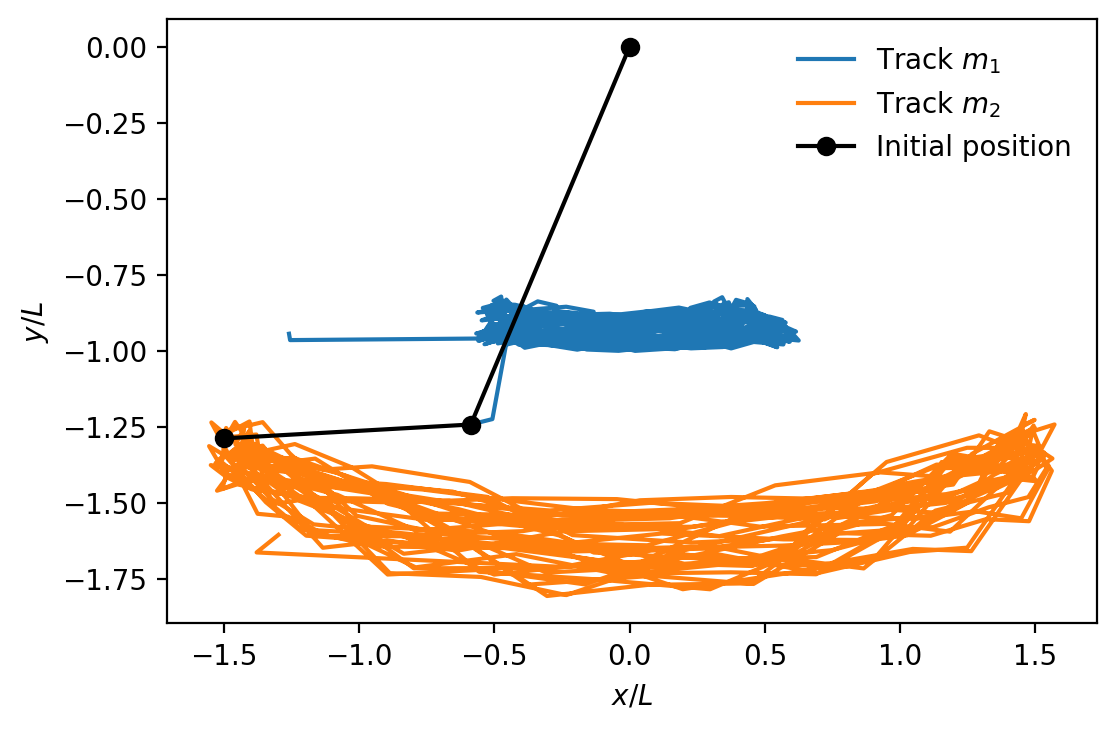

In [22]:
t_test=np.arange(0,50+0.1,0.1)
Input,Output=get_input_target(t_test,windowsize,offset)

#yTest_in2=yTest_in.reshape(yTest_in.shape[0],yTest_in.shape[1],1)
#y_hat=model.predict_on_batch(yTest_in2.reshape(yTest_in2.shape[0],windowsize,1))
Input=Input.reshape(Input.shape[0],Input.shape[1],4)
predictions=model.predict_on_batch(Input).reshape(4,len(t_test)+1-windowsize-offset)

x1_out=predictions[0]
y1_out=predictions[1]
x2_out=predictions[2]
y2_out=predictions[3]


fig,ax=plt.subplots()
ax.plot(x1_out, y1_out, label=r"Track $m_1$")
ax.plot(x2_out, y2_out, label=r"Track $m_2$")
ax.plot([0, x1_out[0], x2_out[0]], [0, y1_out[0], y2_out[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

# 2. How stable is your network to variations in initial conditions? Make a plot of $x$ and $y$ vs time to show the network prediction in comparison to the solution from solve_ivp

In [23]:
ret = solve_ivp(rhs, (0,max(t)), z0, t_eval=t_test, args=(L1, L2, m1, m2, g))
z=ret.y
    #print(np.shape(z))
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]

real_pos = to_cartesian(theta1, w1, theta2, w2, L1, L2)

9.895853581066996
3.873469446855427


(-1.02, -0.7)

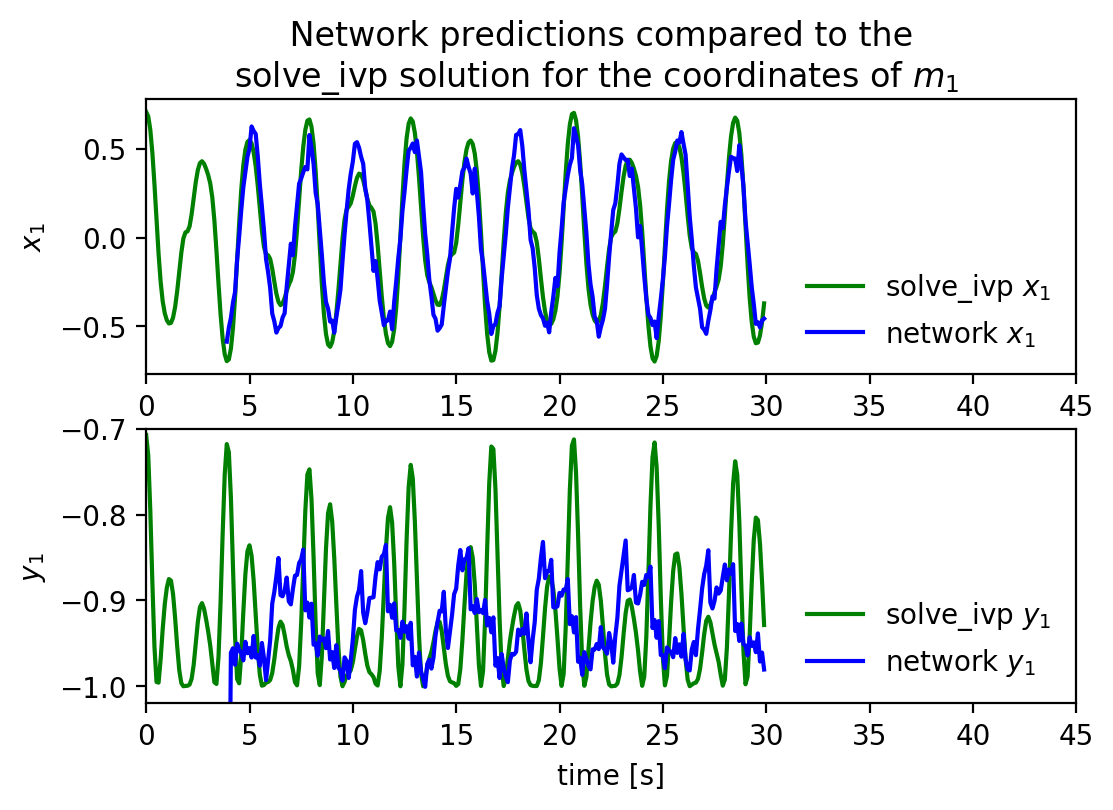

In [24]:
fig, axes = plt.subplots(2)
fig.suptitle(" Network predictions compared to the\nsolve_ivp solution for the coordinates of $m_1$")   # plot the title

i=0
labels=['$x_1$','$y_1$','$x_2$','$y_2$']
for ax in axes:
    ax.plot(t_test[:300],real_pos[i][:300],'-',color="green",label=f'solve_ivp {labels[i]}')   # plot accuracy datapoints
    ax.plot(t_test[windowsize+offset-1:300],predictions[i][:300-(windowsize+offset-1)],'-',color="blue",label=f'network {labels[i]}')   # plot accuracy datapoints
    print(np.sum(np.square(real_pos[i][windowsize+offset-1:]-predictions[i])))

    ax.set_xlim(0,45)

    ax.set_ylabel(f"{labels[i]}")                  # plot y axis label
    ax.legend(loc='lower right')                                # add legend
    i+=1

axes[1].set_xlabel('time [s]')
axes[1].set_ylim(-1.02,-0.7)

2.866943887264353
32.72501699218372


Text(0.5, 0, 'time [s]')

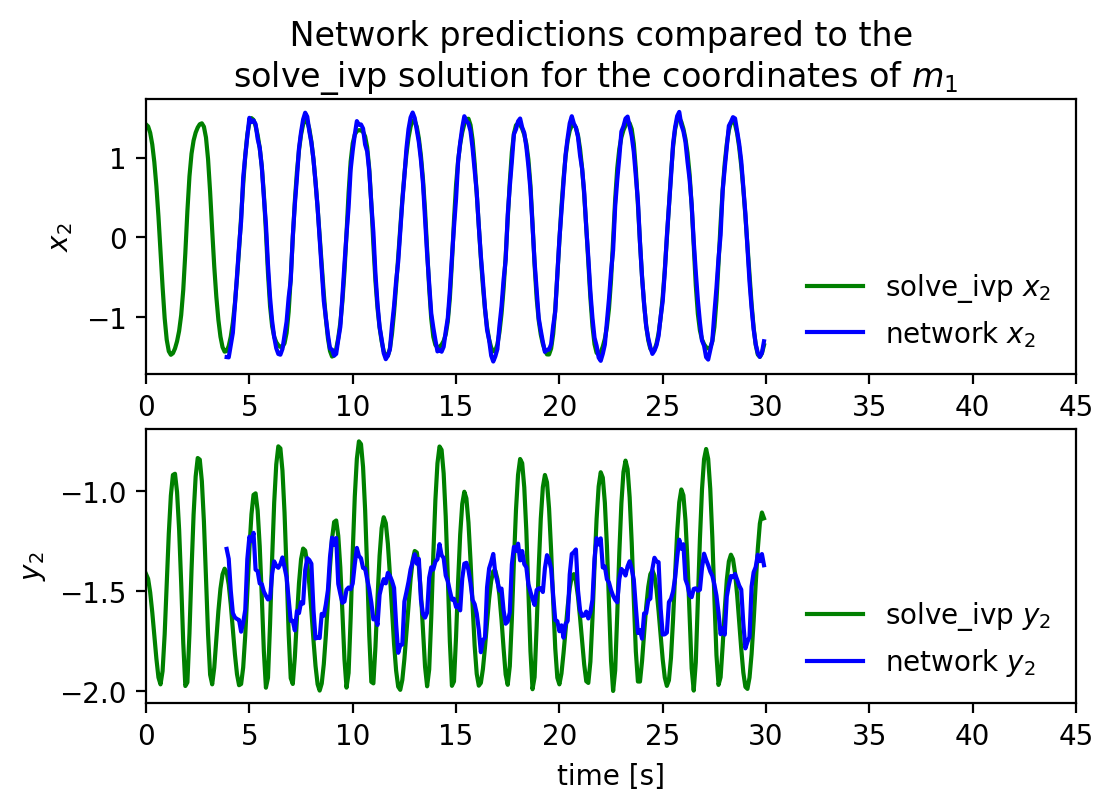

In [25]:
fig, axes = plt.subplots(2)
fig.suptitle(" Network predictions compared to the\nsolve_ivp solution for the coordinates of $m_1$")   # plot the title

i=2
labels=['$x_1$','$y_1$','$x_2$','$y_2$']
for ax in axes:
    ax.plot(t_test[:300],real_pos[i][:300],'-',color="green",label=f'solve_ivp {labels[i]}')   # plot accuracy datapoints
    ax.plot(t_test[windowsize+offset-1:300],predictions[i][:300-(windowsize+offset-1)],'-',color="blue",label=f'network {labels[i]}')   # plot accuracy datapoints
    print(np.sum(np.square(real_pos[i][windowsize+offset-1:]-predictions[i])))

    ax.set_xlim(0,45)

    ax.set_ylabel(f"{labels[i]}")                  # plot y axis label
    ax.legend(loc='lower right')                                # add legend
    i+=1

axes[1].set_xlabel('time [s]')
#axes[1].set_ylim(-1.02,-0.7)

As it can be seen the network is better at predicting the x-coordinate of mass 1 and 2 rather than the y-coordinate. This could be because the trends of the y-coordinate are the more complex and therefore harder to predict. Also we can see that the network is better at predicting the position of mass 2 than the position of mass 1.

# 3. How far into the future can a network predict? Make a plot showing how the deviation between predicted position and actual position (from solve_ivp above) vary as a function of extrapolation time from $t=t_0 + 20 \delta t$ to $t=t_0 + 100 \delta t$  (e.g. for each extrapolation time, train a new version of the network and then plot the performance)

Now we need to compute the differences between the data-points predicted by the *solve_ivp* function and the network predictions

In [26]:
def network_solve_diff(t,windowsize,offset,model):
    Input,Output=get_input_target(t,windowsize,offset)
    predictions=model.predict_on_batch(Input).reshape(4,len(t)+1-windowsize-offset)
    
    ret = solve_ivp(rhs, (0,max(t)), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]

    real_pos = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    
    diff=[]
    for i in range(4):
        diff.append(np.sum(np.abs(predictions[i]-real_pos[i][windowsize+offset-1:])))
         
    return diff

We will train a new version of the network for each extrapolation time, i.e. offset, and then plot the performance

In [27]:
future_steps=np.arange(20,100+10,10)
diff_x1,diff_y1, diff_x2,diff_y2=[],[],[],[]

for future in tqdm(future_steps):
    offset=future
    model=create_model()
    steps=300  #Number of training steps
    #costs=np.zeros(steps)  #Array for plotting cost
    for i in range(steps):
        tmax, dt = 50, 0.1
        t = np.arange(0, tmax+dt, dt)
    
        Input,Target=get_input_target(t,windowsize,offset)
        model.train_on_batch(Input,Target) #Train the network
    diff_x1.append(network_solve_diff(t,windowsize,offset,model)[0])
    diff_y1.append(network_solve_diff(t,windowsize,offset,model)[1])
    diff_x2.append(network_solve_diff(t,windowsize,offset,model)[2])
    diff_y2.append(network_solve_diff(t,windowsize,offset,model)[3])

100%|██████████| 9/9 [04:22<00:00, 29.21s/it]


Text(0.04, 0.5, 'Deviation')

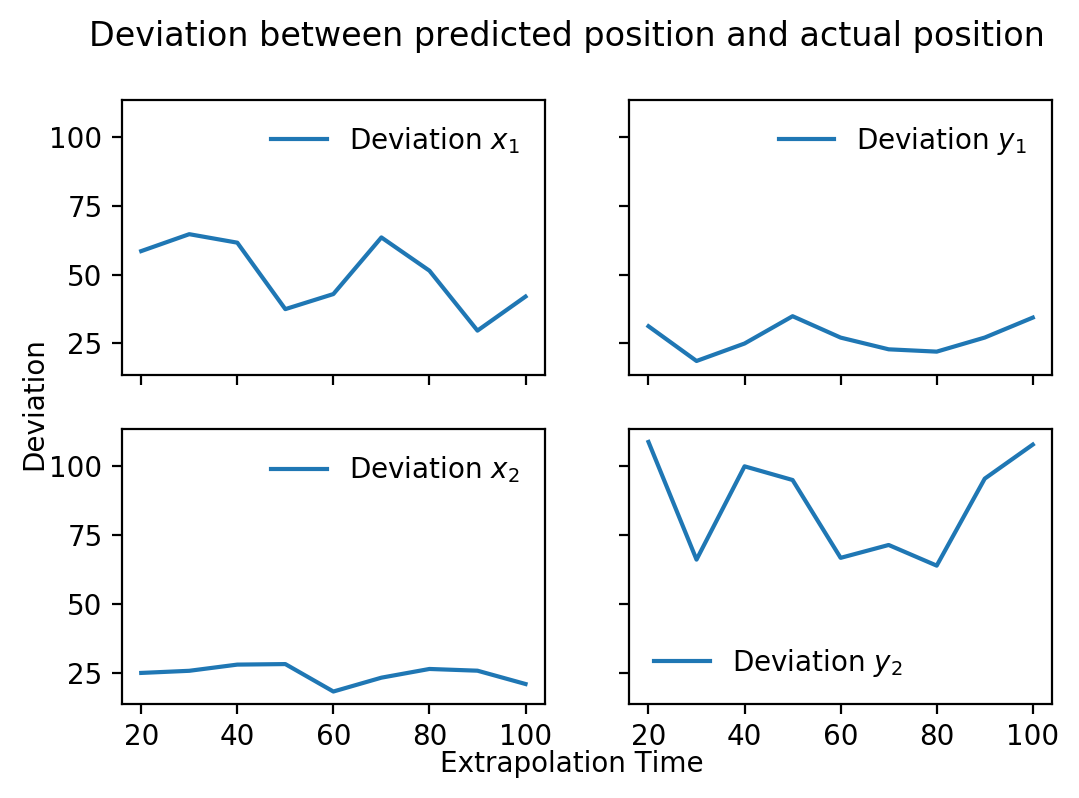

In [28]:
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(2, 2,sharex=True, sharey=True)
fig.suptitle('Deviation between predicted position and actual position ')
labels=['$x_1$','$y_1$','$x_2$','$y_2$']

axes[0,0].plot(future_steps, diff_x1,label=f'Deviation {labels[0]}')
axes[0,0].legend()
axes[0,1].plot(future_steps, diff_y1,label=f'Deviation {labels[1]}')
axes[0,1].legend()
axes[1,0].plot(future_steps, diff_x2,label=f'Deviation {labels[2]}')
axes[1,0].legend()
axes[1,1].plot(future_steps, diff_y2,label=f'Deviation {labels[3]}')
axes[1,1].legend()
    
fig.text(0.5, 0.04, 'Extrapolation Time', ha='center')
fig.text(0.04, 0.5, 'Deviation', va='center', rotation='vertical')  

We will also plot the total difference against extrapolation time.

Text(0.5, 1.0, 'Summed deviations for each coordinate \nbetween predicted position and actual position ')

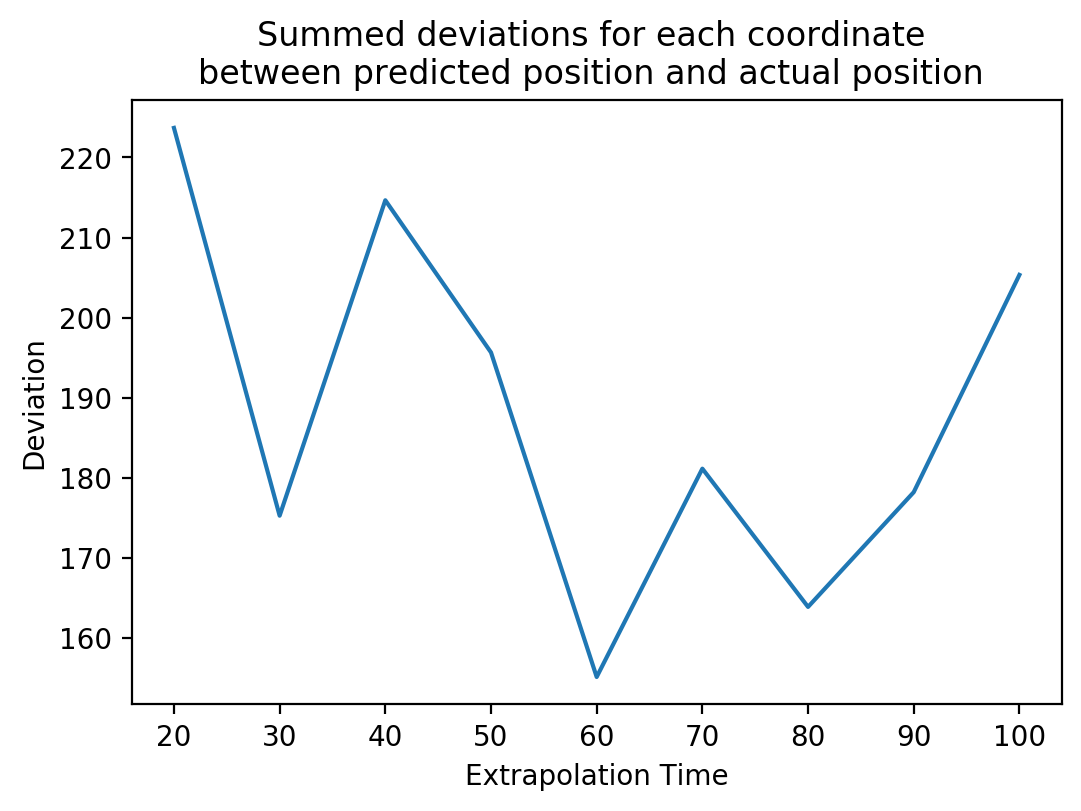

In [29]:
tot_diff=np.array(diff_x1)+np.array(diff_y1)+np.array(diff_x2)+np.array(diff_y2)
fig=plt.figure
plt.plot(future_steps,tot_diff)

plt.xlabel('Extrapolation Time')
plt.ylabel('Deviation')
plt.title('Summed deviations for each coordinate \nbetween predicted position and actual position ')

In [30]:
differences_1=[diff_x1,diff_y1,diff_x2,diff_y2]

As it can be seen the deviation of the network predictions from the real solutions is not increasing as a function of extrapolation time. As the network makes predictions further into the future, the deviation seems to follow a chaotic trend. This might be due to the fact that both coordinates for the two masses follow an wavelike trend which repeats itself after a certain period of time. Therefore predicting values 1 period forward or n periods forward int he future should not make any difference for the model.

Therefore the minimum in the deviation charts of the single coordinates could correspond to the periods of the wavelike trends of the coordinates themselves.

# Changing initial condition to $z_0 = [\pi/2,0,\pi/2,0]$

Now we will train the network for 300 steps, changing the initial condition $z_0$, and plot the cost against the steps.

100%|██████████| 300/300 [00:41<00:00,  7.30it/s]


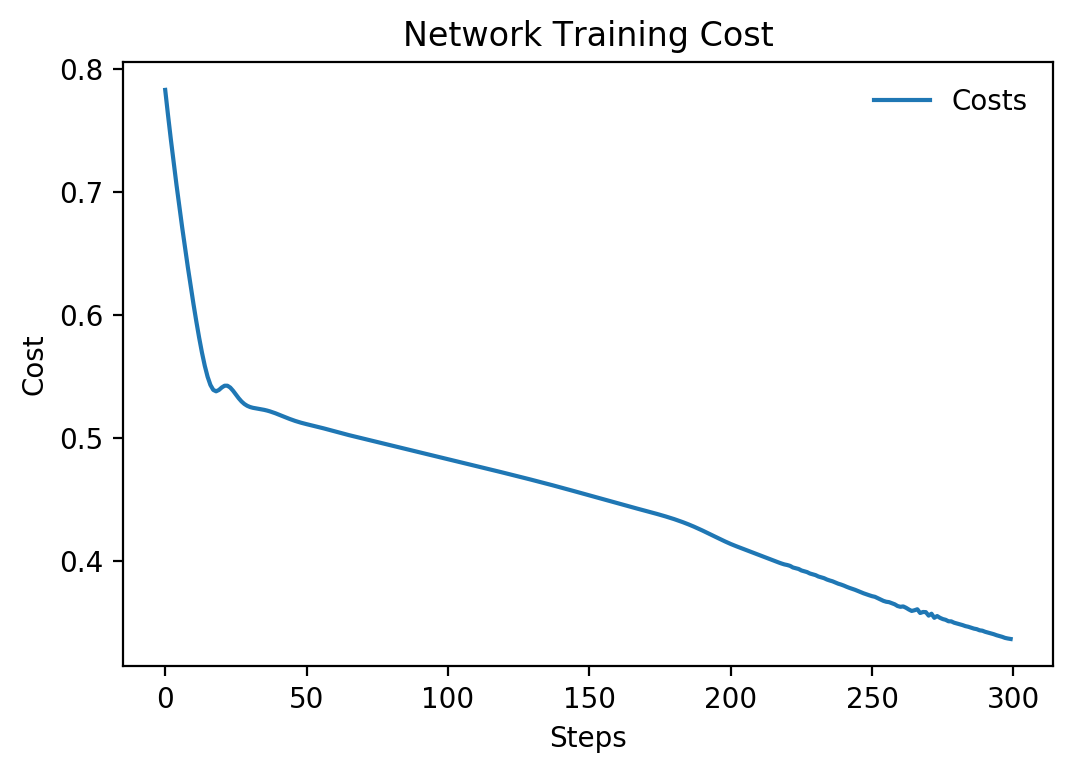

In [31]:
model=create_model()

windowsize=20

z0=[np.pi/2,0,np.pi/2,0]
offset=20
steps=300  #Number of training steps
costs=np.zeros(steps)  #Array for plotting cost
for i in tqdm(range(steps)):
    tmax, dt = 50, 0.1
    t = np.arange(0, tmax+dt, dt)
    
    Input,Target=get_input_target(t,windowsize,offset)
    costs[i]=model.train_on_batch(Input,Target) #Train the network

#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
#ax.set_xlim(0,0.4)
ax.legend()

In [32]:
print(f'The final costs is: {costs[-1]}')

The final costs is: 0.3364449441432953


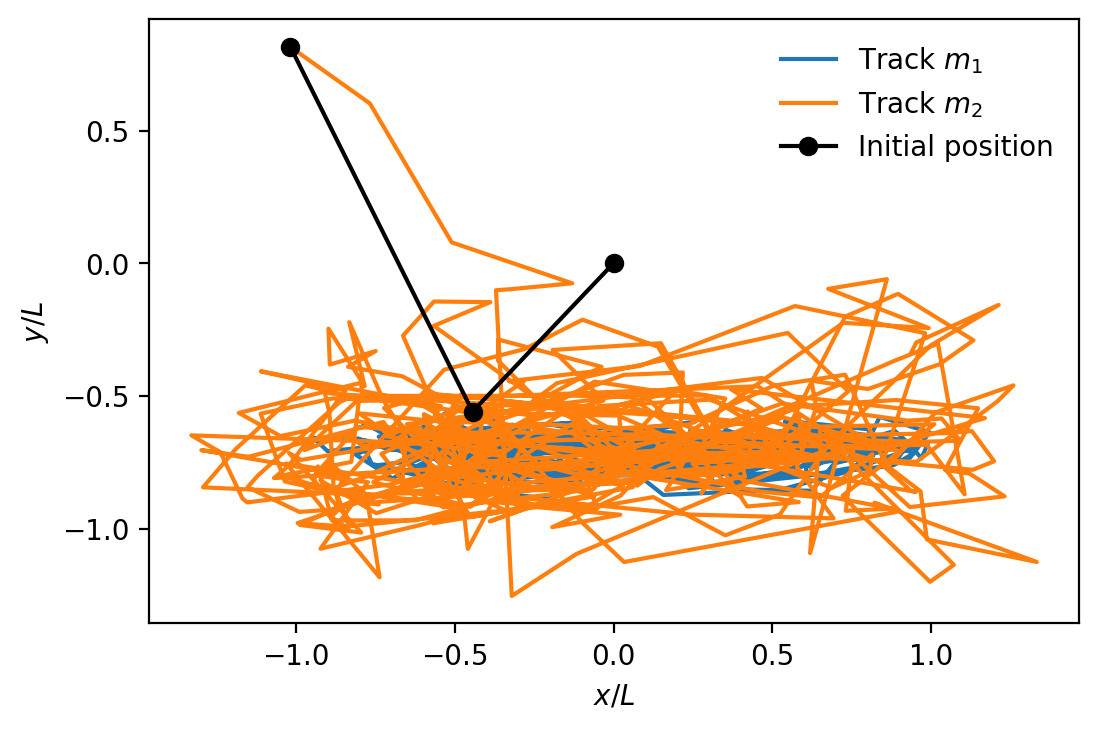

In [33]:
t_test=np.arange(0,50+0.1,0.1)
Input,Output=get_input_target(t_test,windowsize,offset)

#yTest_in2=yTest_in.reshape(yTest_in.shape[0],yTest_in.shape[1],1)
#y_hat=model.predict_on_batch(yTest_in2.reshape(yTest_in2.shape[0],windowsize,1))
Input=Input.reshape(Input.shape[0],Input.shape[1],4)
predictions=model.predict_on_batch(Input).reshape(4,len(t_test)+1-windowsize-offset)

x1_out=predictions[0]
y1_out=predictions[1]
x2_out=predictions[2]
y2_out=predictions[3]


fig,ax=plt.subplots()
ax.plot(x1_out, y1_out, label=r"Track $m_1$")
ax.plot(x2_out, y2_out, label=r"Track $m_2$")
ax.plot([0, x1_out[0], x2_out[0]], [0, y1_out[0], y2_out[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

We can now see that the ability of the network to correctly predict the trajectories of the two masses have worsened.
This is because the change in initial conditions makes these trajectories much more complex and therefore harder to predict.

In [34]:
ret = solve_ivp(rhs, (0,max(t)), z0, t_eval=t_test, args=(L1, L2, m1, m2, g))
z=ret.y
    #print(np.shape(z))
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]

real_pos = to_cartesian(theta1, w1, theta2, w2, L1, L2)

Text(0.5, 0, 'time [s]')

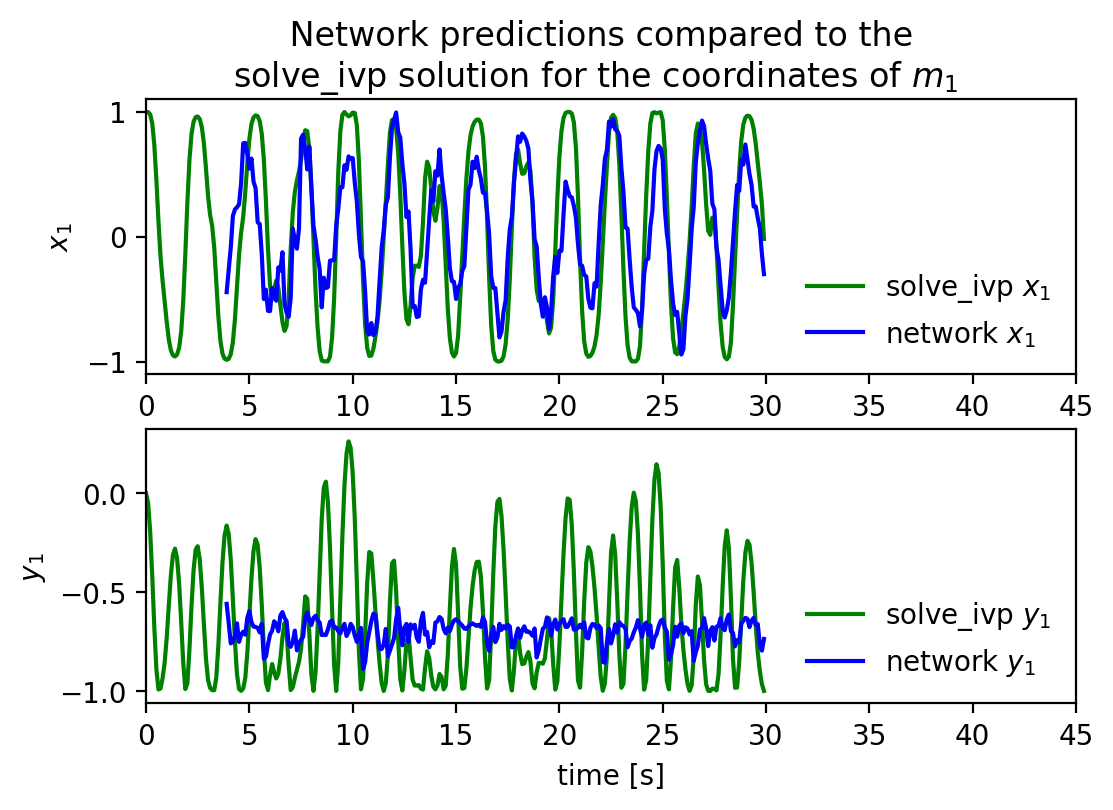

In [35]:
fig, axes = plt.subplots(2)
fig.suptitle(" Network predictions compared to the\nsolve_ivp solution for the coordinates of $m_1$")   # plot the title

i=0
labels=['$x_1$','$y_1$','$x_2$','$y_2$']
for ax in axes:
    ax.plot(t_test[:300],real_pos[i][:300],'-',color="green",label=f'solve_ivp {labels[i]}')   # plot accuracy datapoints
    ax.plot(t_test[windowsize+offset-1:300],predictions[i][:300-(windowsize+offset-1)],'-',color="blue",label=f'network {labels[i]}')   # plot accuracy datapoints

    ax.set_xlim(0,45)

    ax.set_ylabel(f"{labels[i]}")                  # plot y axis label
    ax.legend(loc='lower right')                                # add legend
    i+=1

axes[1].set_xlabel('time [s]')
#axes[1].set_ylim(-1.02,-0.7)

Text(0.5, 0, 'time [s]')

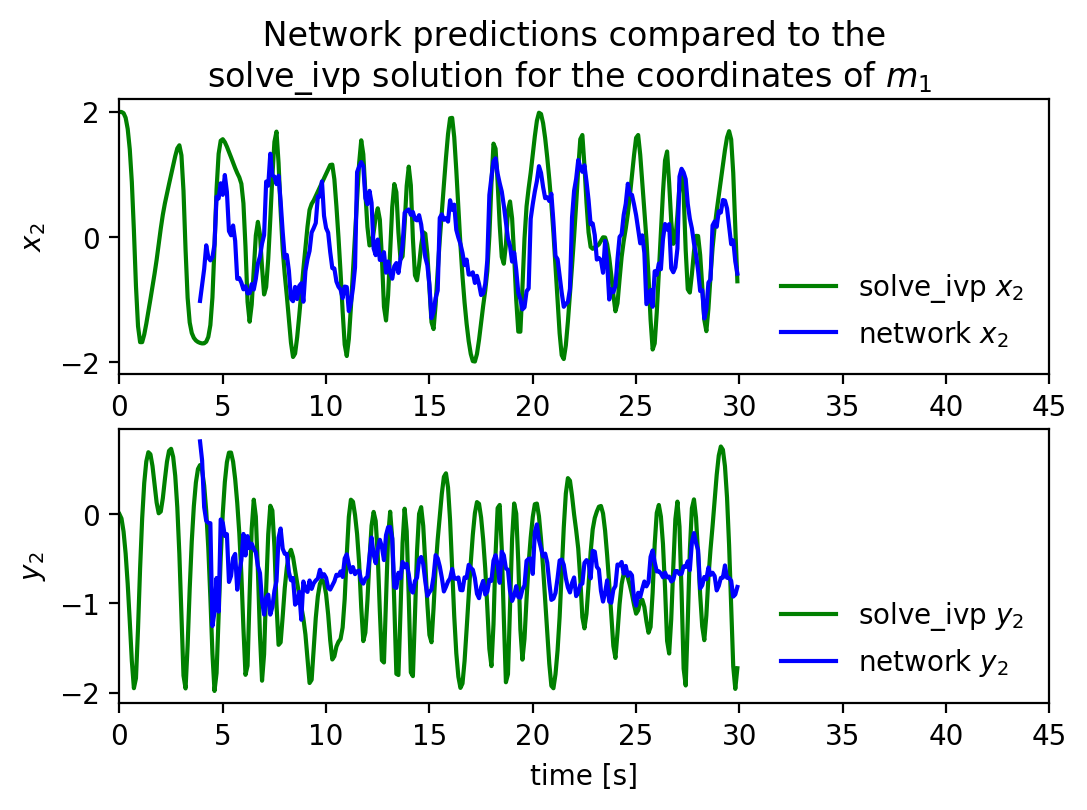

In [36]:
fig, axes = plt.subplots(2)
fig.suptitle(" Network predictions compared to the\nsolve_ivp solution for the coordinates of $m_1$")   # plot the title

i=2
labels=['$x_1$','$y_1$','$x_2$','$y_2$']
for ax in axes:
    ax.plot(t_test[:300],real_pos[i][:300],'-',color="green",label=f'solve_ivp {labels[i]}')   # plot accuracy datapoints
    ax.plot(t_test[windowsize+offset-1:300],predictions[i][:300-(windowsize+offset-1)],'-',color="blue",label=f'network {labels[i]}')   # plot accuracy datapoints

    ax.set_xlim(0,45)

    ax.set_ylabel(f"{labels[i]}")                  # plot y axis label
    ax.legend(loc='lower right')                                # add legend
    i+=1

axes[1].set_xlabel('time [s]')

As it can be seen the network is still better at predicting the x-coordinate of mass 1 and 2 rather than the y-coordinate. This could be because the trends of the y-coordinate are the more complex and therefore harder to predict. Also the model struggles to predict the increased sudden changes in the wavelike trends of the coordinates and ends up cutting out most of the peaks and troughs.

In [37]:
future_steps=np.arange(20,100+10,10)
diff_x1,diff_y1, diff_x2,diff_y2=[],[],[],[]

for future in tqdm(future_steps):
    offset=future
    model=create_model()
    steps=300  #Number of training steps
    #costs=np.zeros(steps)  #Array for plotting cost
    for i in range(steps):
        tmax, dt = 50, 0.1
        t = np.arange(0, tmax+dt, dt)
    
        Input,Target=get_input_target(t,windowsize,offset)
        model.train_on_batch(Input,Target) #Train the network
    diff_x1.append(network_solve_diff(t,windowsize,offset,model)[0])
    diff_y1.append(network_solve_diff(t,windowsize,offset,model)[1])
    diff_x2.append(network_solve_diff(t,windowsize,offset,model)[2])
    diff_y2.append(network_solve_diff(t,windowsize,offset,model)[3])

  0%|          | 0/9 [00:00<?, ?it/s]

 11%|█         | 1/9 [00:38<05:06, 38.33s/it]

100%|██████████| 9/9 [05:40<00:00, 37.88s/it]


Text(0.04, 0.5, 'Deviation')

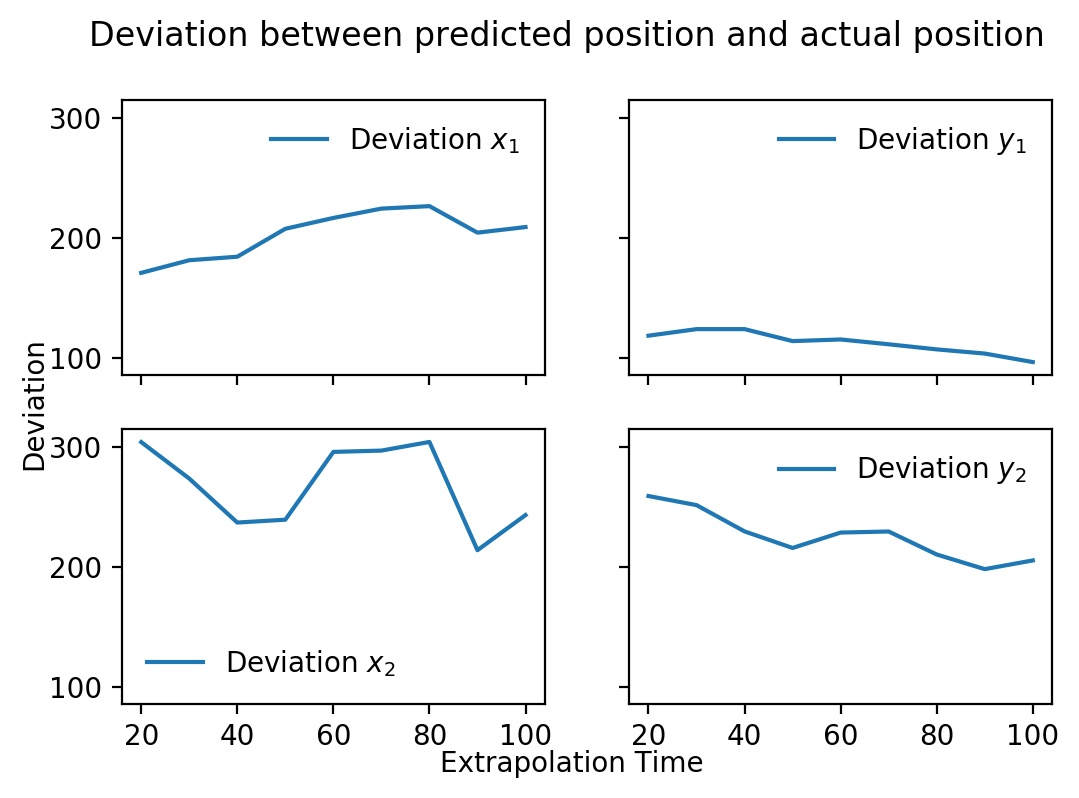

In [38]:
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(2, 2,sharex=True, sharey=True)
fig.suptitle('Deviation between predicted position and actual position ')
labels=['$x_1$','$y_1$','$x_2$','$y_2$']

axes[0,0].plot(future_steps, diff_x1,label=f'Deviation {labels[0]}')
axes[0,0].legend()
axes[0,1].plot(future_steps, diff_y1,label=f'Deviation {labels[1]}')
axes[0,1].legend()
axes[1,0].plot(future_steps, diff_x2,label=f'Deviation {labels[2]}')
axes[1,0].legend()
axes[1,1].plot(future_steps, diff_y2,label=f'Deviation {labels[3]}')
axes[1,1].legend()
    
fig.text(0.5, 0.04, 'Extrapolation Time', ha='center')
fig.text(0.04, 0.5, 'Deviation', va='center', rotation='vertical')  

Text(0.5, 1.0, 'Summed deviations for each coordinate \nbetween predicted position and actual position ')

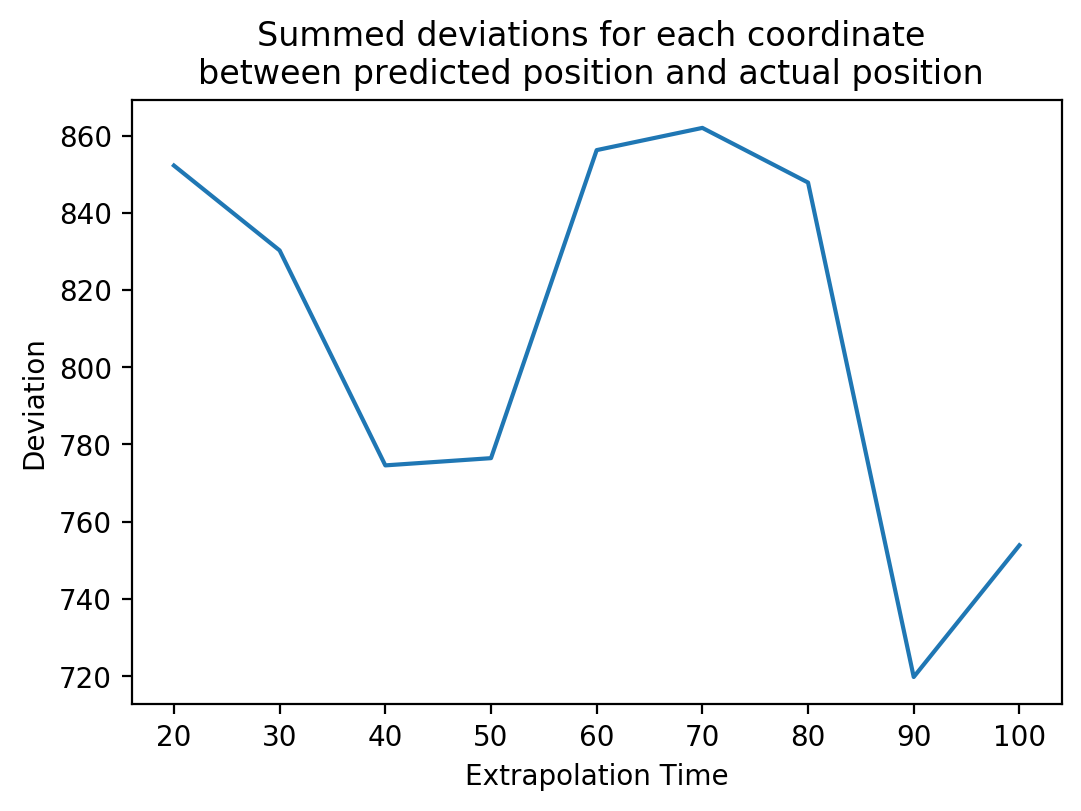

In [39]:
tot_diff=np.array(diff_x1)+np.array(diff_y1)+np.array(diff_x2)+np.array(diff_y2)
fig=plt.figure
plt.plot(future_steps,tot_diff)

plt.xlabel('Extrapolation Time')
plt.ylabel('Deviation')
plt.title('Summed deviations for each coordinate \nbetween predicted position and actual position ')

In [40]:
differences_2=[diff_x1,diff_y1,diff_x2,diff_y2]

The deviations have increased for all coordinates after changing the initial conditions since the masses in the double pendulum system are now following more complex trajectories. It is also harder to define a trend in the deviations plots themselves as they do not seem to show a recurring behaviour as observed before.

# 5. Training only on $m_2$ position

In [41]:
def create_model():
    model=keras.models.Sequential()
    model.add(keras.layers.LSTM(40,input_shape=(None,2),return_sequences=False)) # LSTM layer with 50 neurons
    #model.add(keras.layers.LSTM(40,input_shape=(None,40),return_sequences=False)) # LSTM layer with 50 neurons
    model.add(keras.layers.Dense(4,activation="linear"))
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

100%|██████████| 300/300 [00:32<00:00,  9.24it/s]


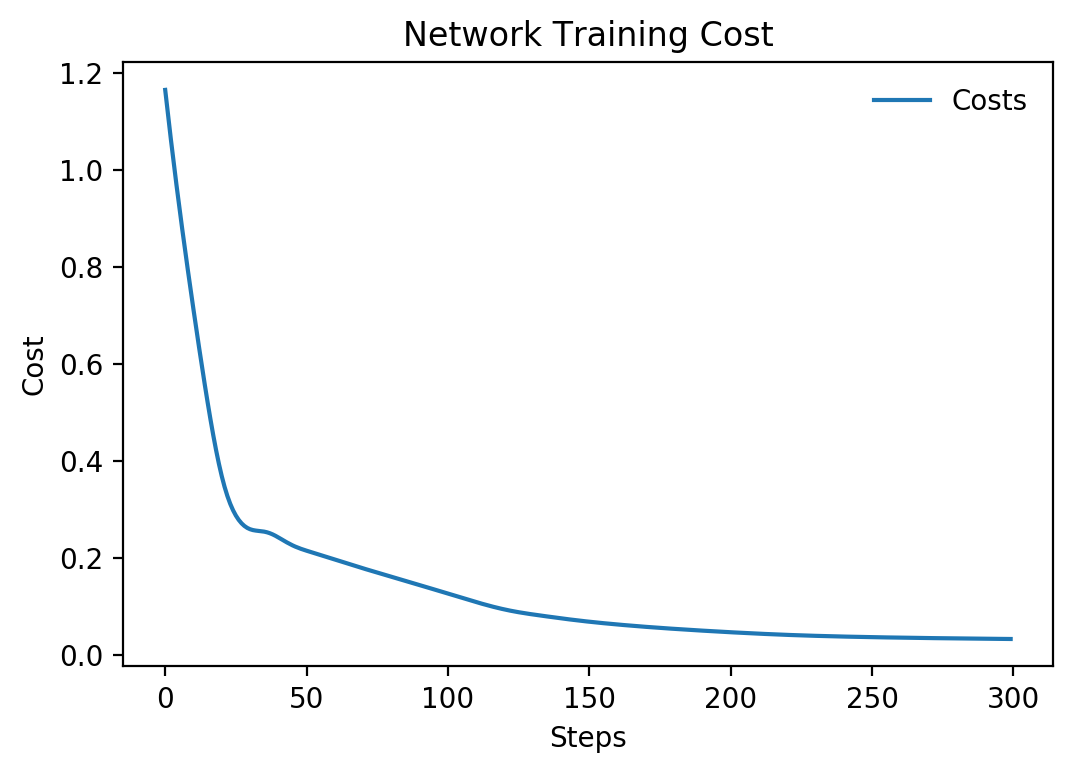

In [42]:
model=create_model()

z0=[np.pi/4,0,np.pi/4,0]
windowsize,offset=20,20
steps=300  #Number of training steps
costs=np.zeros(steps)  #Array for plotting cost
for i in tqdm(range(steps)):
    tmax, dt = 50, 0.1
    t = np.arange(0, tmax+dt, dt)
    
    Input,Target=get_input_target(t,windowsize,offset)
    Input=Input[:,:,2:]
    Target=Target[:,:]
    costs[i]=model.train_on_batch(Input,Target) #Train the network

#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
#ax.set_xlim(0,0.4)
ax.legend()

In [43]:
print(f'The final costs is: {costs[-1]}')

The final costs is: 0.03326907753944397


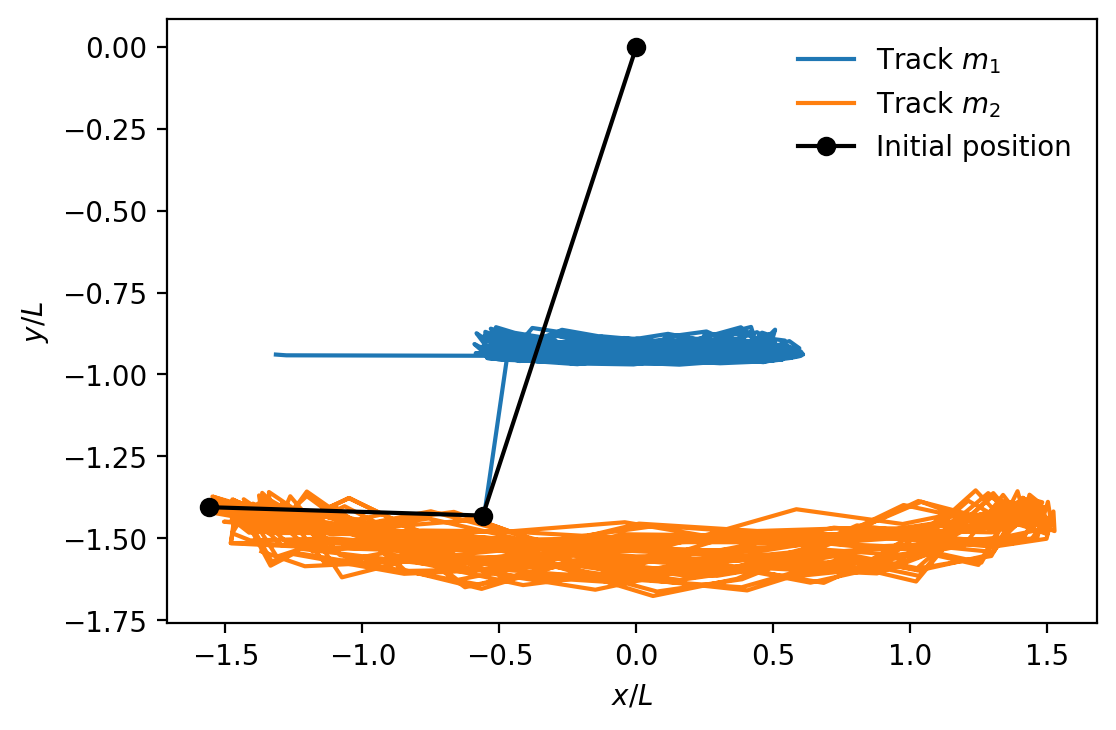

In [44]:
t_test=np.arange(0,50+0.1,0.1)
Input,Output=get_input_target(t_test,windowsize,offset)

#yTest_in2=yTest_in.reshape(yTest_in.shape[0],yTest_in.shape[1],1)
#y_hat=model.predict_on_batch(yTest_in2.reshape(yTest_in2.shape[0],windowsize,1))
Input=Input[:,:,2:]
predictions=model.predict_on_batch(Input).reshape(4,len(t_test)+1-windowsize-offset)

x1_out=predictions[0]
y1_out=predictions[1]
x2_out=predictions[2]
y2_out=predictions[3]


fig,ax=plt.subplots()
ax.plot(x1_out, y1_out, label=r"Track $m_1$")
ax.plot(x2_out, y2_out, label=r"Track $m_2$")
ax.plot([0, x1_out[0], x2_out[0]], [0, y1_out[0], y2_out[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

In [45]:
ret = solve_ivp(rhs, (0,max(t)), z0, t_eval=t_test, args=(L1, L2, m1, m2, g))
z=ret.y
    #print(np.shape(z))
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]
real_pos = to_cartesian(theta1, w1, theta2, w2, L1, L2)

(-1.05, -0.7)

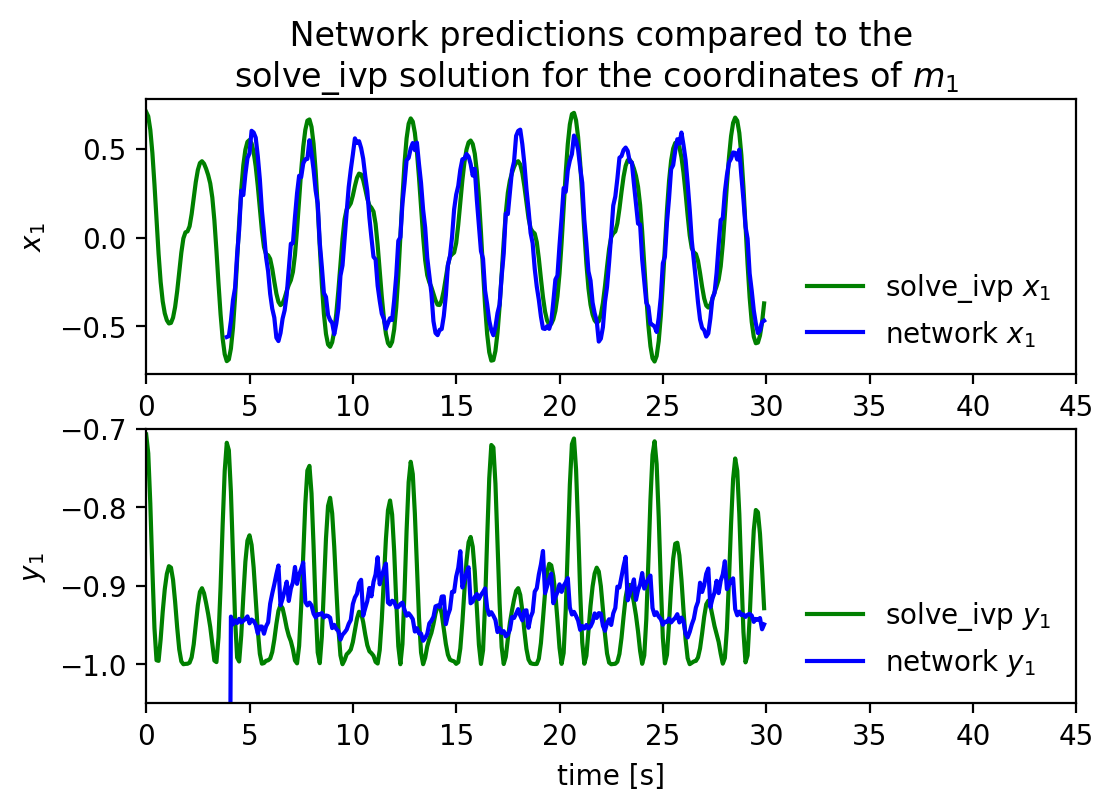

In [46]:
fig, axes = plt.subplots(2)
fig.suptitle(" Network predictions compared to the\nsolve_ivp solution for the coordinates of $m_1$")   # plot the title

i=0
labels=['$x_1$','$y_1$','$x_2$','$y_2$']
for ax in axes:
    ax.plot(t_test[:300],real_pos[i][:300],'-',color="green",label=f'solve_ivp {labels[i]}')   # plot accuracy datapoints
    ax.plot(t_test[windowsize+offset-1:300],predictions[i][:300-(windowsize+offset-1)],'-',color="blue",label=f'network {labels[i]}')   # plot accuracy datapoints

    ax.set_xlim(0,45)

    ax.set_ylabel(f"{labels[i]}")                  # plot y axis label
    ax.legend(loc='lower right')                                # add legend
    i+=1

axes[1].set_xlabel('time [s]')
axes[1].set_ylim(-1.05,-0.7)

Text(0.5, 0, 'time [s]')

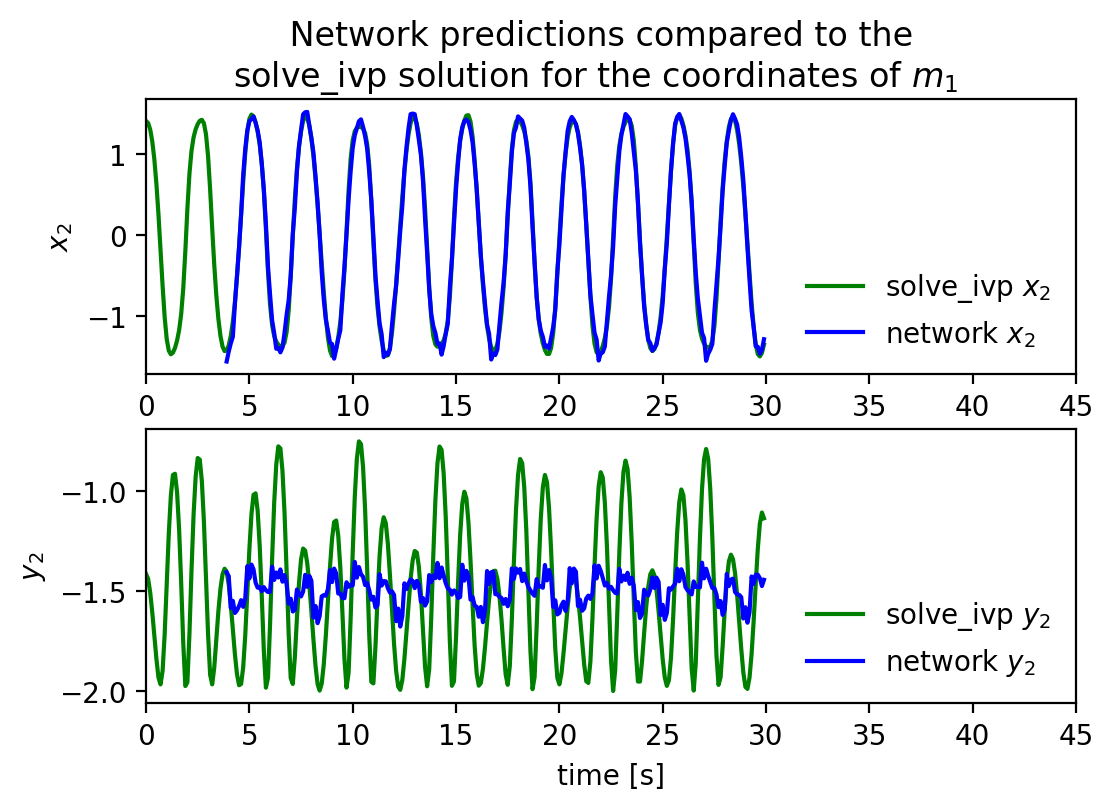

In [47]:
fig, axes = plt.subplots(2)
fig.suptitle(" Network predictions compared to the\nsolve_ivp solution for the coordinates of $m_1$")   # plot the title

i=2
labels=['$x_1$','$y_1$','$x_2$','$y_2$']
for ax in axes:
    ax.plot(t_test[:300],real_pos[i][:300],'-',color="green",label=f'solve_ivp {labels[i]}')   # plot accuracy datapoints
    ax.plot(t_test[windowsize+offset-1:300],predictions[i][:300-(windowsize+offset-1)],'-',color="blue",label=f'network {labels[i]}')   # plot accuracy datapoints

    ax.set_xlim(0,45)

    ax.set_ylabel(f"{labels[i]}")                  # plot y axis label
    ax.legend(loc='lower right')                                # add legend
    i+=1

axes[1].set_xlabel('time [s]')

In [48]:
def network_solve_diff(t,windowsize,offset,model):
    predictions=model.predict_on_batch(Input).reshape(4,len(t)+1-windowsize-offset)
    
    ret = solve_ivp(rhs, (0,max(t)), z0, t_eval=t, args=(L1, L2, m1, m2, g))
    z=ret.y
    theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]

    real_pos = to_cartesian(theta1, w1, theta2, w2, L1, L2)
    
    diff=[]
    for i in range(4):
        diff.append(np.sum(np.abs(predictions[i]-real_pos[i][windowsize+offset-1:])))
         
    return diff

In [49]:
future_steps=np.arange(20,100+10,10)
diff_x1,diff_y1, diff_x2,diff_y2=[],[],[],[]

for future in tqdm(future_steps):
    offset=future
    model=create_model()
    steps=300  #Number of training steps
    #costs=np.zeros(steps)  #Array for plotting cost
    for i in range(steps):
        tmax, dt = 50, 0.1
        t = np.arange(0, tmax+dt, dt)
    
        Input,Target=get_input_target(t,windowsize,offset)
        Input=Input[:,:,2:]
        Target=Target[:,:]
        model.train_on_batch(Input,Target) #Train the network
    diff_x1.append(network_solve_diff(t,windowsize,offset,model)[0])
    diff_y1.append(network_solve_diff(t,windowsize,offset,model)[1])
    diff_x2.append(network_solve_diff(t,windowsize,offset,model)[2])
    diff_y2.append(network_solve_diff(t,windowsize,offset,model)[3])

100%|██████████| 9/9 [04:21<00:00, 29.08s/it]


In [50]:
differences_3=[diff_x1,diff_y1,diff_x2,diff_y2]

Text(0.04, 0.5, 'Deviation')

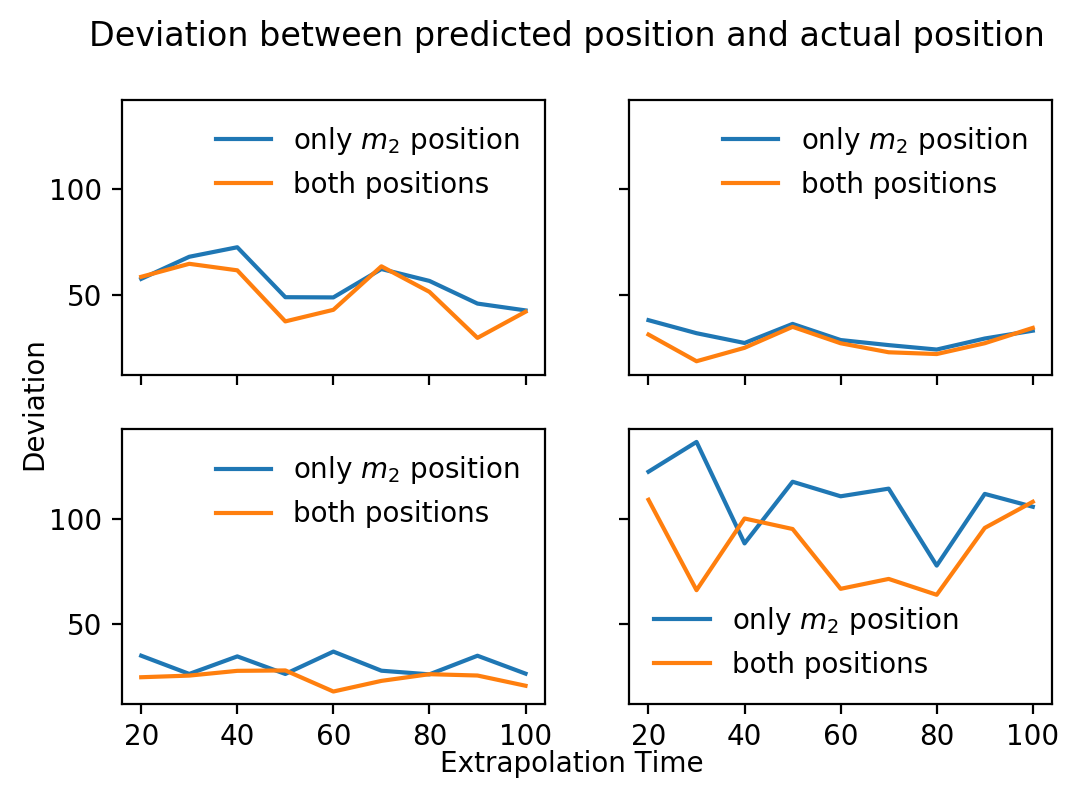

In [51]:
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(2, 2,sharex=True, sharey=True)
fig.suptitle('Deviation between predicted position and actual position ')
labels=['$x_1$','$y_1$','$x_2$','$y_2$']

axes[0,0].plot(future_steps, diff_x1,label='only $m_2$ position')
axes[0,0].plot(future_steps, differences_1[0],label='both positions')
axes[0,0].legend()
axes[0,1].plot(future_steps, diff_y1,label='only $m_2$ position')
axes[0,1].plot(future_steps, differences_1[1],label='both positions')
axes[0,1].legend()
axes[1,0].plot(future_steps, diff_x2,label='only $m_2$ position')
axes[1,0].plot(future_steps, differences_1[2],label='both positions')
axes[1,0].legend()
axes[1,1].plot(future_steps, diff_y2,label='only $m_2$ position')
axes[1,1].plot(future_steps, differences_1[3],label='both positions')
axes[1,1].legend()
    
fig.text(0.5, 0.04, 'Extrapolation Time', ha='center')
fig.text(0.04, 0.5, 'Deviation', va='center', rotation='vertical')  

Text(0.5, 1.0, 'Summed deviations for each coordinate \nbetween predicted position and actual position ')

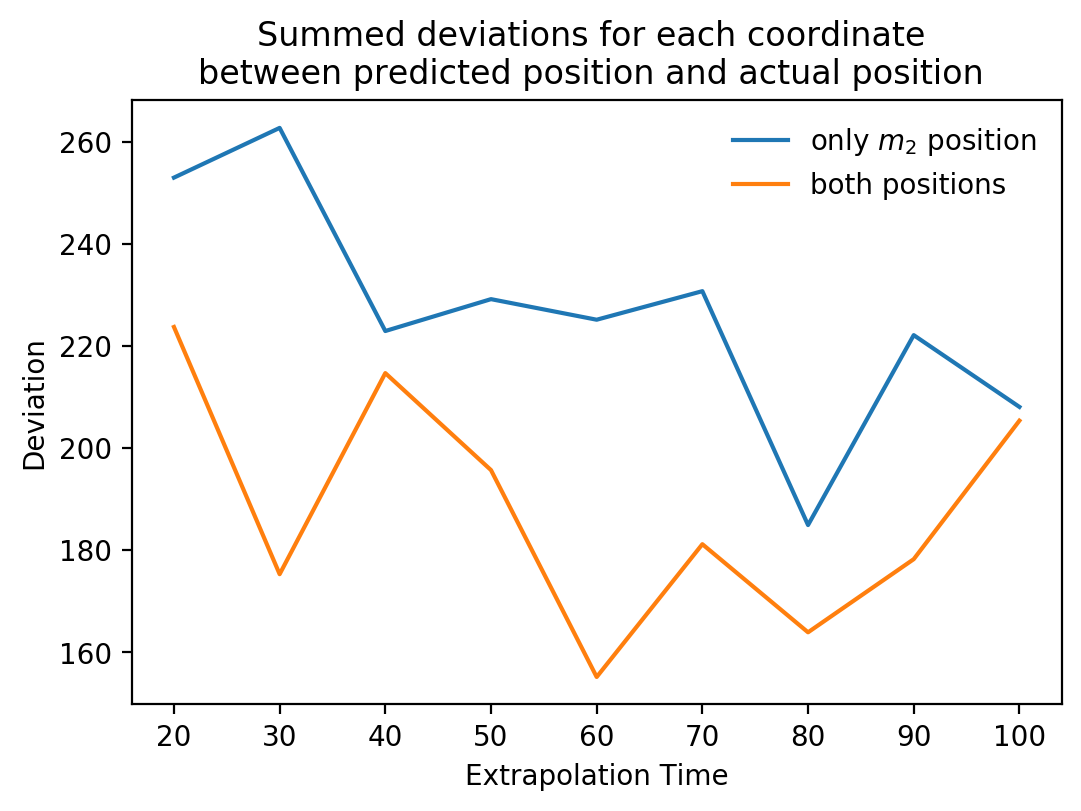

In [52]:
tot_diff_1=np.array(diff_x1)+np.array(diff_y1)+np.array(diff_x2)+np.array(diff_y2)
tot_diff_2=np.array(differences_1[0])+np.array(differences_1[1])+np.array(differences_1[2])+np.array(differences_1[3])

fig=plt.figure
plt.plot(future_steps,tot_diff_1,label='only $m_2$ position')
plt.plot(future_steps,tot_diff_2,label='both positions')
plt.legend();

plt.xlabel('Extrapolation Time')
plt.ylabel('Deviation')
plt.title('Summed deviations for each coordinate \nbetween predicted position and actual position ')

# Training on position $m_2$ and $z0=[\pi/2,0,\pi/2,0]$

100%|██████████| 300/300 [00:42<00:00,  7.08it/s]


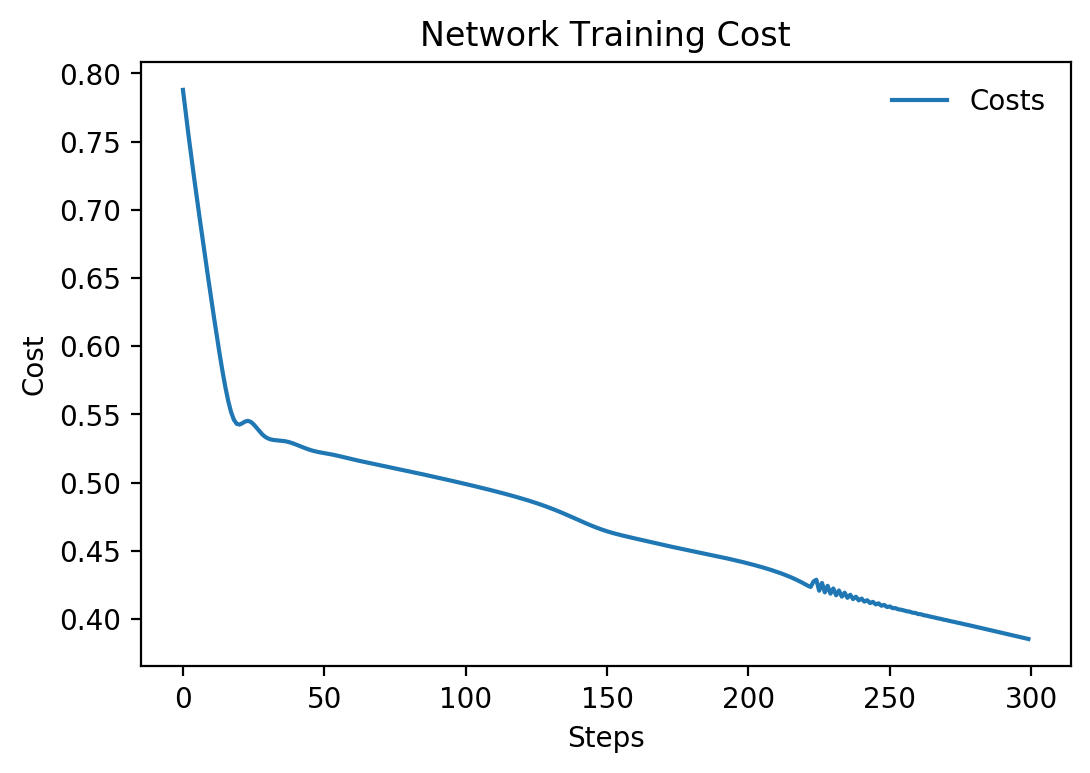

In [53]:
model=create_model()

windowsize=20

z0=[np.pi/2,0,np.pi/2,0]
offset=20
steps=300  #Number of training steps
costs=np.zeros(steps)  #Array for plotting cost
for i in tqdm(range(steps)):
    tmax, dt = 50, 0.1
    t = np.arange(0, tmax+dt, dt)
    
    
    Input,Target=get_input_target(t,windowsize,offset)
    Input=Input[:,:,2:]
    Target=Target[:,:]
    costs[i]=model.train_on_batch(Input,Target) #Train the network

#Plot costs vs steps
fig,ax=plt.subplots()
ax.plot(np.arange(steps),costs,label=r"Costs")
ax.set_xlabel("Steps")
ax.set_ylabel("Cost")
ax.set_title("Network Training Cost")
#ax.set_xlim(0,0.4)
ax.legend()

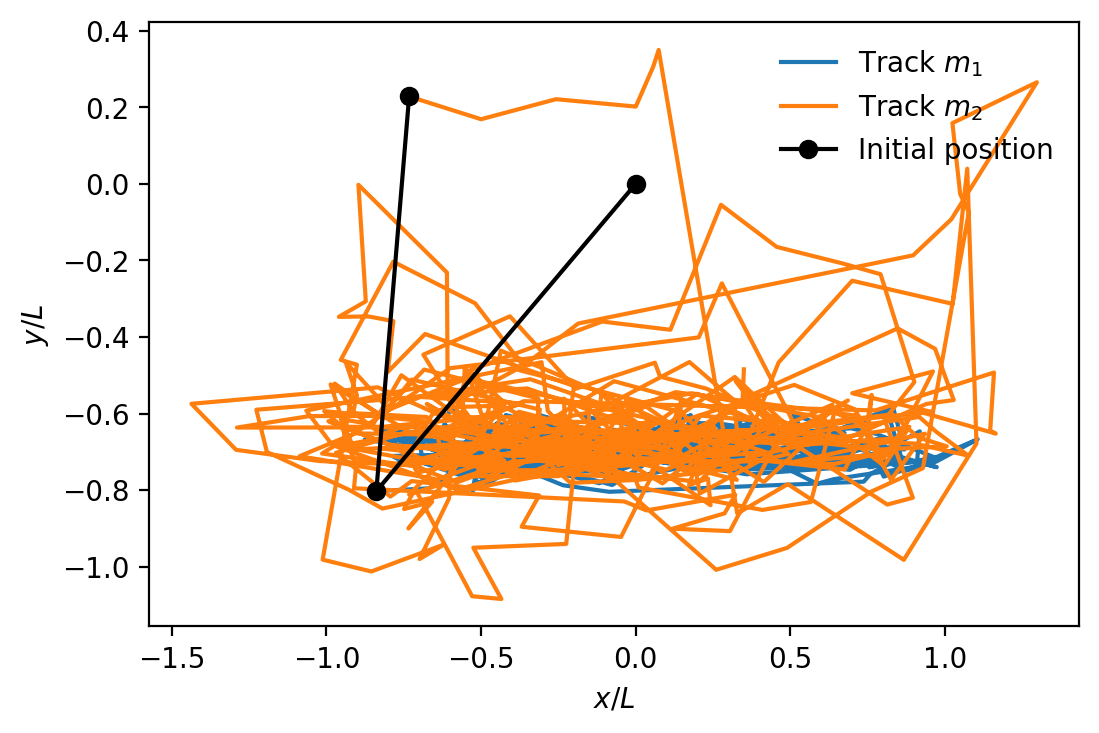

In [54]:
t_test=np.arange(0,50+0.1,0.1)
Input,Output=get_input_target(t_test,windowsize,offset)

#yTest_in2=yTest_in.reshape(yTest_in.shape[0],yTest_in.shape[1],1)
#y_hat=model.predict_on_batch(yTest_in2.reshape(yTest_in2.shape[0],windowsize,1))
Input=Input[:,:,2:]
predictions=model.predict_on_batch(Input).reshape(4,len(t_test)+1-windowsize-offset)

x1_out=predictions[0]
y1_out=predictions[1]
x2_out=predictions[2]
y2_out=predictions[3]


fig,ax=plt.subplots()
ax.plot(x1_out, y1_out, label=r"Track $m_1$")
ax.plot(x2_out, y2_out, label=r"Track $m_2$")
ax.plot([0, x1_out[0], x2_out[0]], [0, y1_out[0], y2_out[0]], "-o", label="Initial position", c='k')
plt.ylabel(r"$y/L$")
plt.xlabel(r"$x/L$")
ax.legend()

In [55]:
ret = solve_ivp(rhs, (0,max(t)), z0, t_eval=t_test, args=(L1, L2, m1, m2, g))
z=ret.y
    #print(np.shape(z))
theta1, w1, theta2, w2 = z[0], z[1], z[2], z[3]

real_pos = to_cartesian(theta1, w1, theta2, w2, L1, L2)

Text(0.5, 0, 'time [s]')

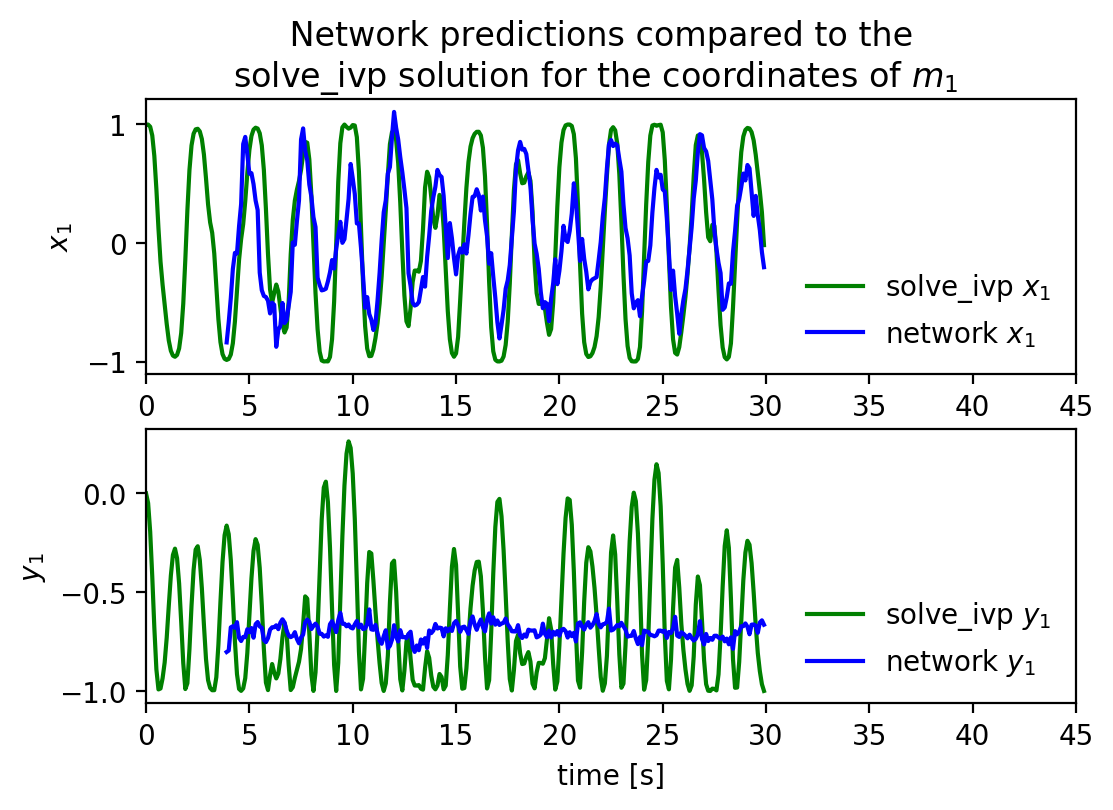

In [56]:
fig, axes = plt.subplots(2)
fig.suptitle(" Network predictions compared to the\nsolve_ivp solution for the coordinates of $m_1$")   # plot the title

i=0
labels=['$x_1$','$y_1$','$x_2$','$y_2$']
for ax in axes:
    ax.plot(t_test[:300],real_pos[i][:300],'-',color="green",label=f'solve_ivp {labels[i]}')   # plot accuracy datapoints
    ax.plot(t_test[windowsize+offset-1:300],predictions[i][:300-(windowsize+offset-1)],'-',color="blue",label=f'network {labels[i]}')   # plot accuracy datapoints

    ax.set_xlim(0,45)

    ax.set_ylabel(f"{labels[i]}")                  # plot y axis label
    ax.legend(loc='lower right')                                # add legend
    i+=1

axes[1].set_xlabel('time [s]')
#axes[1].set_ylim(-1.02,-0.7)

Text(0.5, 0, 'time [s]')

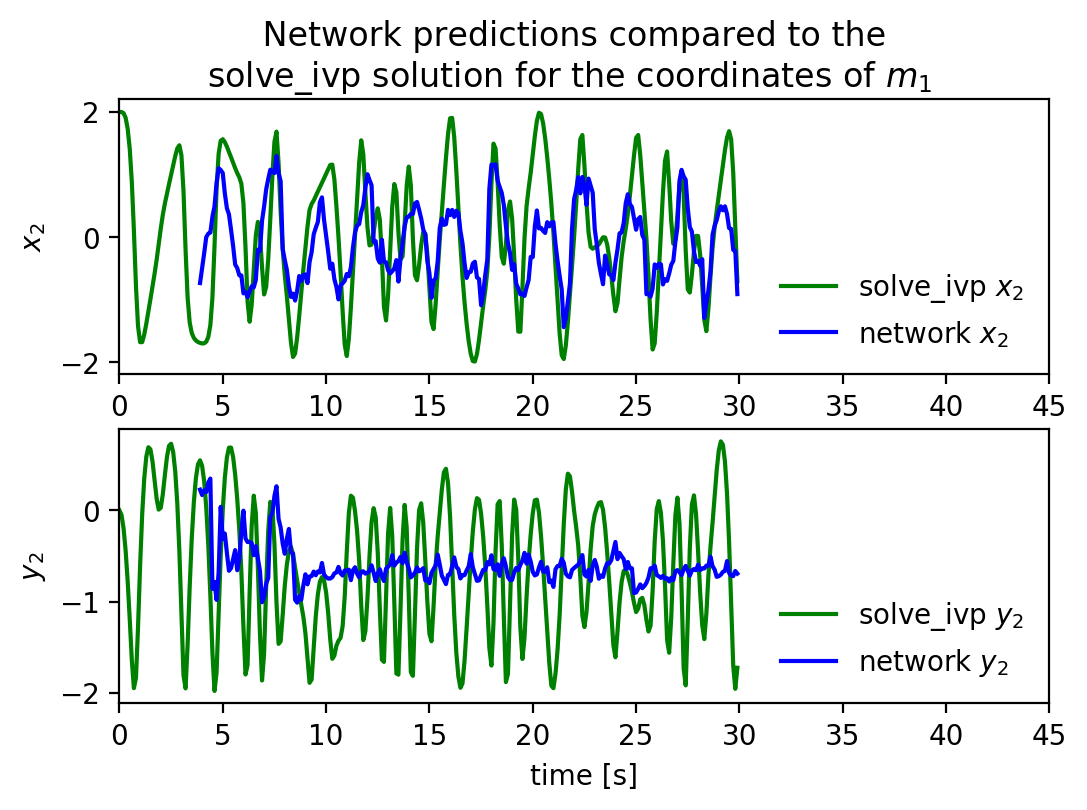

In [57]:
fig, axes = plt.subplots(2)
fig.suptitle(" Network predictions compared to the\nsolve_ivp solution for the coordinates of $m_1$")   # plot the title

i=2
labels=['$x_1$','$y_1$','$x_2$','$y_2$']
for ax in axes:
    ax.plot(t_test[:300],real_pos[i][:300],'-',color="green",label=f'solve_ivp {labels[i]}')   # plot accuracy datapoints
    ax.plot(t_test[windowsize+offset-1:300],predictions[i][:300-(windowsize+offset-1)],'-',color="blue",label=f'network {labels[i]}')   # plot accuracy datapoints

    ax.set_xlim(0,45)

    ax.set_ylabel(f"{labels[i]}")                  # plot y axis label
    ax.legend(loc='lower right')                                # add legend
    i+=1

axes[1].set_xlabel('time [s]')

In [58]:
future_steps=np.arange(20,100+10,10)
diff_x1,diff_y1, diff_x2,diff_y2=[],[],[],[]

for future in tqdm(future_steps):
    offset=future
    model=create_model()
    steps=300  #Number of training steps
    #costs=np.zeros(steps)  #Array for plotting cost
    for i in range(steps):
        tmax, dt = 50, 0.1
        t = np.arange(0, tmax+dt, dt)
    
        Input,Target=get_input_target(t,windowsize,offset)
        Input=Input[:,:,2:]
        Target=Target[:,:]
        model.train_on_batch(Input,Target) #Train the network
    diff_x1.append(network_solve_diff(t,windowsize,offset,model)[0])
    diff_y1.append(network_solve_diff(t,windowsize,offset,model)[1])
    diff_x2.append(network_solve_diff(t,windowsize,offset,model)[2])
    diff_y2.append(network_solve_diff(t,windowsize,offset,model)[3])

100%|██████████| 9/9 [05:34<00:00, 37.18s/it]


In [59]:
differences_4=[diff_x1,diff_y1,diff_x2,diff_y2]

Text(0.04, 0.5, 'Deviation')

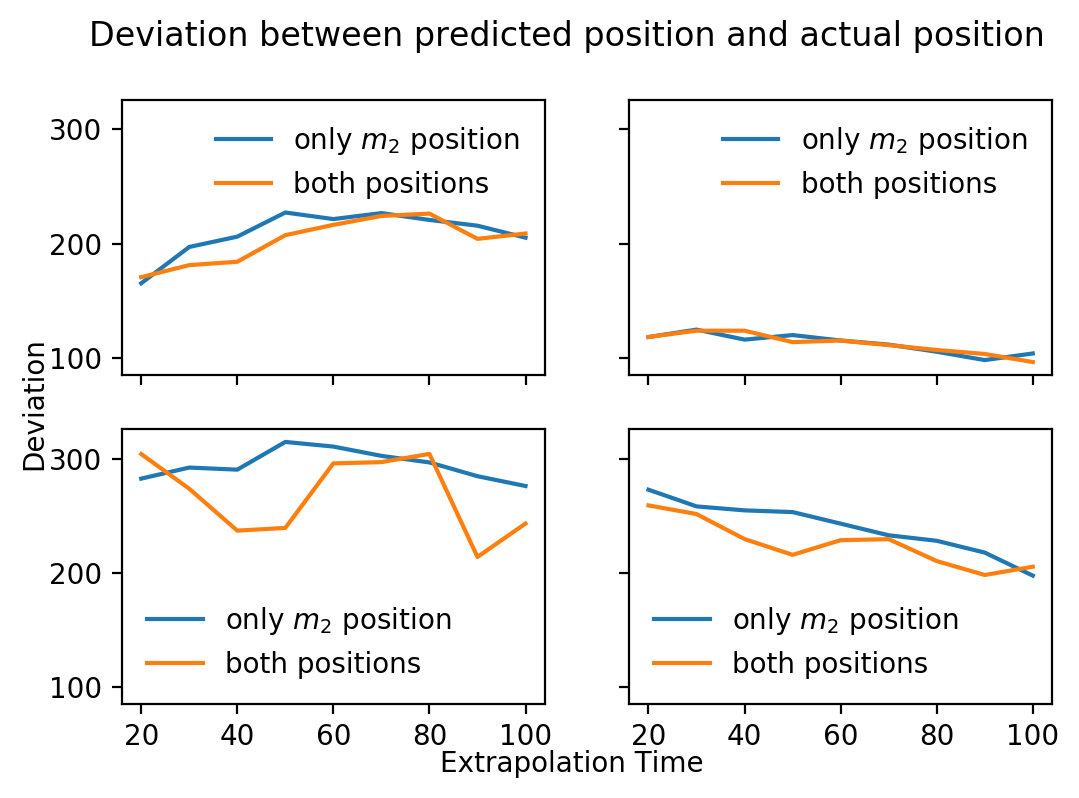

In [60]:
import matplotlib.gridspec as gridspec

fig, axes = plt.subplots(2, 2,sharex=True, sharey=True)
fig.suptitle('Deviation between predicted position and actual position ')
labels=['$x_1$','$y_1$','$x_2$','$y_2$']

axes[0,0].plot(future_steps, diff_x1,label='only $m_2$ position')
axes[0,0].plot(future_steps, differences_2[0],label='both positions')
axes[0,0].legend()
axes[0,1].plot(future_steps, diff_y1,label='only $m_2$ position')
axes[0,1].plot(future_steps, differences_2[1],label='both positions')
axes[0,1].legend()
axes[1,0].plot(future_steps, diff_x2,label='only $m_2$ position')
axes[1,0].plot(future_steps, differences_2[2],label='both positions')
axes[1,0].legend()
axes[1,1].plot(future_steps, diff_y2,label='only $m_2$ position')
axes[1,1].plot(future_steps, differences_2[3],label='both positions')
axes[1,1].legend()
    
fig.text(0.5, 0.04, 'Extrapolation Time', ha='center')
fig.text(0.04, 0.5, 'Deviation', va='center', rotation='vertical') 

Text(0.5, 1.0, 'Summed deviations for each coordinate \nbetween predicted position and actual position ')

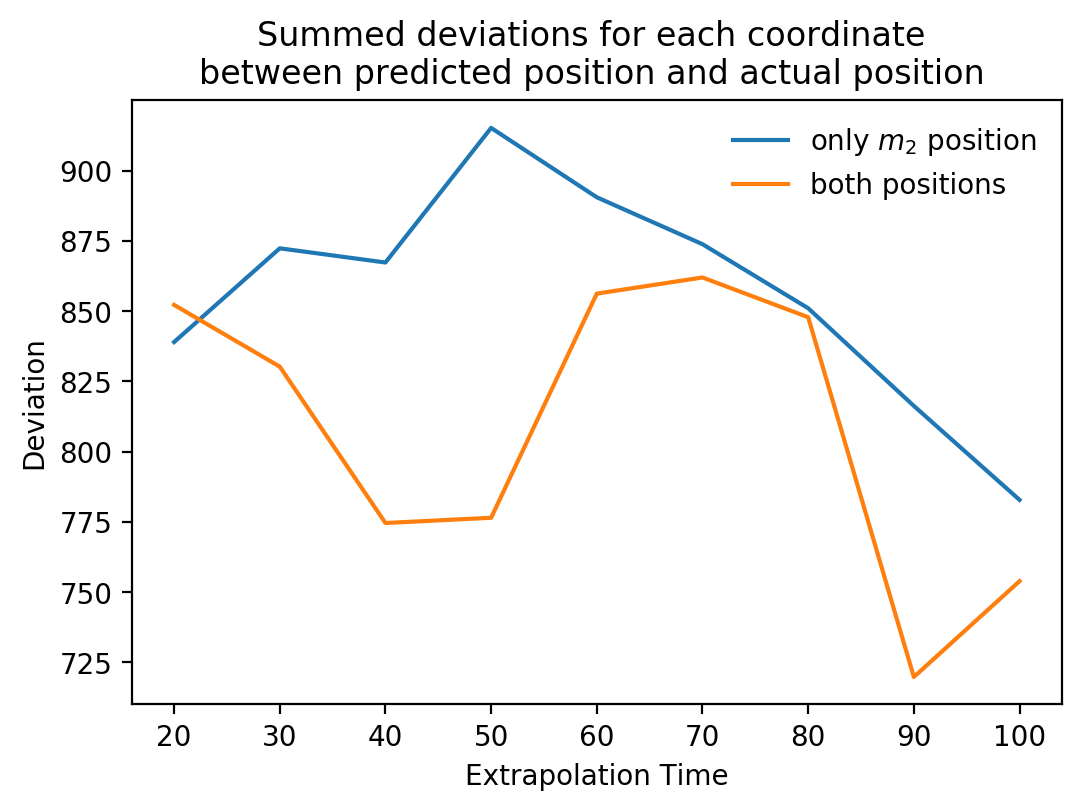

In [61]:
tot_diff_1=np.array(diff_x1)+np.array(diff_y1)+np.array(diff_x2)+np.array(diff_y2)
tot_diff_2=np.array(differences_2[0])+np.array(differences_2[1])+np.array(differences_2[2])+np.array(differences_2[3])

fig=plt.figure
plt.plot(future_steps,tot_diff_1,label='only $m_2$ position')
plt.plot(future_steps,tot_diff_2,label='both positions')
plt.legend();

plt.xlabel('Extrapolation Time')
plt.ylabel('Deviation')
plt.title('Summed deviations for each coordinate \nbetween predicted position and actual position ')

As we can see from the plots above, when the model is trained only on the position of mass $m_2$, its performance is very similar to the model trained on both positions of masses $m_1$ and $m_2$. As a matter of fact, the deviation of the single x and y coordinates between network and real solutions are very similar in both cases. This means that the the position coordinates of mass $m_1$ might not be so relevant in the training of the network to determine the final position of the pendula.